In [1]:
#initializing workspace
import pandas as pd
import matplotlib.pyplot as plt
import trxtools as tt
import os
from pyCRAC.Parsers import GTF2
import pyBigWig
import numpy as np
from trxtools.BigWig import *
from scipy.signal import argrelextrema

pathTAB = "../seq_references/Saccharomyces_cerevisiae.EF4.74.dna.toplevel.shortChrNames.tab"
pathGTF = "../seq_references/Saccharomyces_cerevisiae.EF4.74.shortChNames_with_PolIII_transcripts_extended_slop_intergenic_sort.gtf"
gtf = GTF2.Parse_GTF()
gtf.read_GTF(pathGTF)
gtf.read_TAB(pathTAB)

sequences = pd.read_csv(pathTAB, sep='\t',names=['chr','sequence'],index_col=0)
chr_len = sequences['sequence'].str.len()

pathDir = "../04_BigWig/"
pathMeta = "../06_metadata/"

dinucleotides = pd.read_csv(pathMeta+'/properties_of_dinucleotides.csv', index_col=0)
dinucleotides.index = dinucleotides.reset_index().index.astype(str)+"_"+dinucleotides.index

cleavage_sites = {"5' end" : (300),
                   'A0' : (300+609),
                   'A1' : (300+700),
                   'D'  : (300+2500),
                   'A2' : (300+2712),
                   'A3' : (300+2784),
                   'B1L': (300+2855),
                   'B1S': (300+2861),
                   'E'  : (300+3019),
                   'C1' : (300+3251),
                   'B2' : (300+6647),
                   'B0-1' : (300+6661),
                   'B0-2' : (300+6697),
                   'T1' : (300+6739)}

print(gtf.strand("RDN37-1"), gtf.chromosome("RDN37-1"), gtf.chromosomeCoordinates("RDN37-1"))
print(gtf.strand("RDN37-2"), gtf.chromosome("RDN37-2"), gtf.chromosomeCoordinates("RDN37-2"))

/home/tturowski/TurowskiLab/trxtools/trxtools/profiles.py:220: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def binCollect3(s1=pd.Series(), lengths=[500,72,500], bins=[50, 10, 50]):
/home/tturowski/TurowskiLab/trxtools/trxtools/plotting.py:761: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plotAndFolding(df=pd.DataFrame(),dG=pd.Series(), title="", start=None, stop=None,legend=True,


- chrXII (451785, 457732)
- chrXII (460922, 466869)


In [2]:
def polyA_reads(df_raw_all=pd.DataFrame(), df_raw_polyA=pd.DataFrame(),
                let_in=[], let_out=['wont find this string'],
                count=False):
    
    raw = tt.profiles.preprocess(df_raw_all,let_in=let_in, 
                                     let_out=let_out,stats=False, 
                                     smooth=False,pseudocounts_param=False, ntotal_param=False)
    polyA = tt.profiles.preprocess(df_raw_polyA,let_in=let_in, 
                                     let_out=let_out,stats=False, 
                                     smooth=False,pseudocounts_param=False, ntotal_param=False)
    
    polyA.columns = [i.replace("_polyA","") for i in polyA.columns]
    
    percentage = polyA.sum() / raw.sum()

    fraction_polyA = polyA / raw

    output = tt.profiles.preprocess(fraction_polyA.fillna(0.0),let_in=let_in, 
                                     let_out=let_out,stats=True,
                                     smooth=True,pseudocounts_param=False, ntotal_param=False)

    if count==True:
                return percentage, output
    
    elif count==False:
                print("Fraxction of polyA reads in the dataset:")
                print(percentage)
                return output

# Rpa190

In [3]:
flank = 1000

seq1_flank = tt.methods.reverse_complement(sequences.loc['chrXII'][0][451785-flank:457732+flank])
seq2_flank = tt.methods.reverse_complement(sequences.loc['chrXII'][0][460922-flank:466869+flank])

#loading datasets

data_files_raw = [f for f in os.listdir(pathDir) if 'raw' in f and "bw" in f]
data_files_3end = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" not in f and "bw" in f]
data_files_polyA = [f for f in os.listdir(pathDir) if 'PROFILE_3end' in f and "polyA" in f and "bw" in f]
data_files_5end = [f for f in os.listdir(pathDir) if 'PROFILE_5end' in f and "bw" in f]

print(len(os.listdir(pathDir)))

print(len(data_files_3end))
print(len(data_files_polyA))
print(len(data_files_5end))

df01a_RDN371_datasets_3end = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_3end, gtf=gtf,ranges=flank)
s1_RDN371_sequence = df01a_RDN371_datasets_3end['nucleotide'] #kee[ for future use
df01b_RDN372_datasets_3end = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_3end, gtf=gtf,ranges=flank)
df01_RDN37_3end = df01a_RDN371_datasets_3end.drop('nucleotide',axis='columns') + df01b_RDN372_datasets_3end.drop('nucleotide',axis='columns')

df03a_RDN371_datasets_polyA = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_polyA, gtf=gtf,ranges=flank)
df03b_RDN372_datasets_polyA = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_polyA, gtf=gtf,ranges=flank)
df03_RDN37_polyA = df03a_RDN371_datasets_polyA.drop('nucleotide',axis='columns') + df03b_RDN372_datasets_polyA.drop('nucleotide',axis='columns')

df04a_RDN371_datasets_raw = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_raw, gtf=gtf,ranges=flank)
df04b_RDN372_datasets_raw = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_raw, gtf=gtf,ranges=flank)
df04_RDN37_raw = df04a_RDN371_datasets_raw.drop('nucleotide',axis='columns') + df04b_RDN372_datasets_raw.drop('nucleotide',axis='columns')

df05a_RDN371_datasets_5end = geneFromBigWig(gene_name="RDN37-1", data_path=pathDir, data_files=data_files_5end, gtf=gtf,ranges=flank)
df05b_RDN372_datasets_5end = geneFromBigWig(gene_name="RDN37-2", data_path=pathDir, data_files=data_files_5end, gtf=gtf,ranges=flank)
df05_RDN37_5end = df05a_RDN371_datasets_5end.drop('nucleotide',axis='columns') + df05b_RDN372_datasets_5end.drop('nucleotide',axis='columns')


1287
250
250
250


/home/tturowski/TurowskiLab/trxtools/trxtools/BigWig.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_t1[name] = getSeqData(gene_name, data_path, name, gtf, ranges=ranges)
/home/tturowski/TurowskiLab/trxtools/trxtools/BigWig.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_t1[name] = getSeqData(gene_name, data_path, name, gtf, ranges=ranges)
/home/tturowski/TurowskiLab/trxtools/trxtools/BigWig.py:62: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times

In [4]:
df11_Rpa190_3end = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Rpa190HTP'], 
                                     let_out=['hmo1','0s','25rDNA','UVA',
                                         'Rnt1','rrp44','trf4','air1','rat1',
                                         'h_','C_'],stats=True)

peaks = tt.profiles.findPeaks(df11_Rpa190_3end['median'][:7200],order=45,window=80)

Experiments: 
['XX000000_Rpa190HTP_wt_none_2_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_3_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_4_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_1_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_6_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_5_PROFILE_3end']


Experiments: 
['XX000000_Rpa190HTP_wt_none_2_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_3_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_4_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_1_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_6_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_5_PROFILE_3end']
Experiments: 
['XX000000_Rpa190HTP_wt_none_5_PROFILE_3end_polyA', 'XX000000_Rpa190HTP_wt_none_3_PROFILE_3end_polyA', 'XX000000_Rpa190HTP_wt_none_4_PROFILE_3end_polyA', 'XX000000_Rpa190HTP_wt_none_6_PROFILE_3end_polyA', 'XX000000_Rpa190HTP_wt_none_2_PROFILE_3end_polyA', 'XX000000_Rpa190HTP_wt_none_1_PROFILE_3end_polyA']
Experiments: 
['XX000000_Rpa190HTP_wt_none_1_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_2_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_3_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_4_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_5_PROFILE_3end', 'XX000000_Rpa190HTP_wt_none_6_PROFILE_3end']
Fraxction of polyA reads in the dataset:
XX000000_Rpa190HTP_wt_none_1_PROFILE_3end    0.024320
XX000000_Rpa19

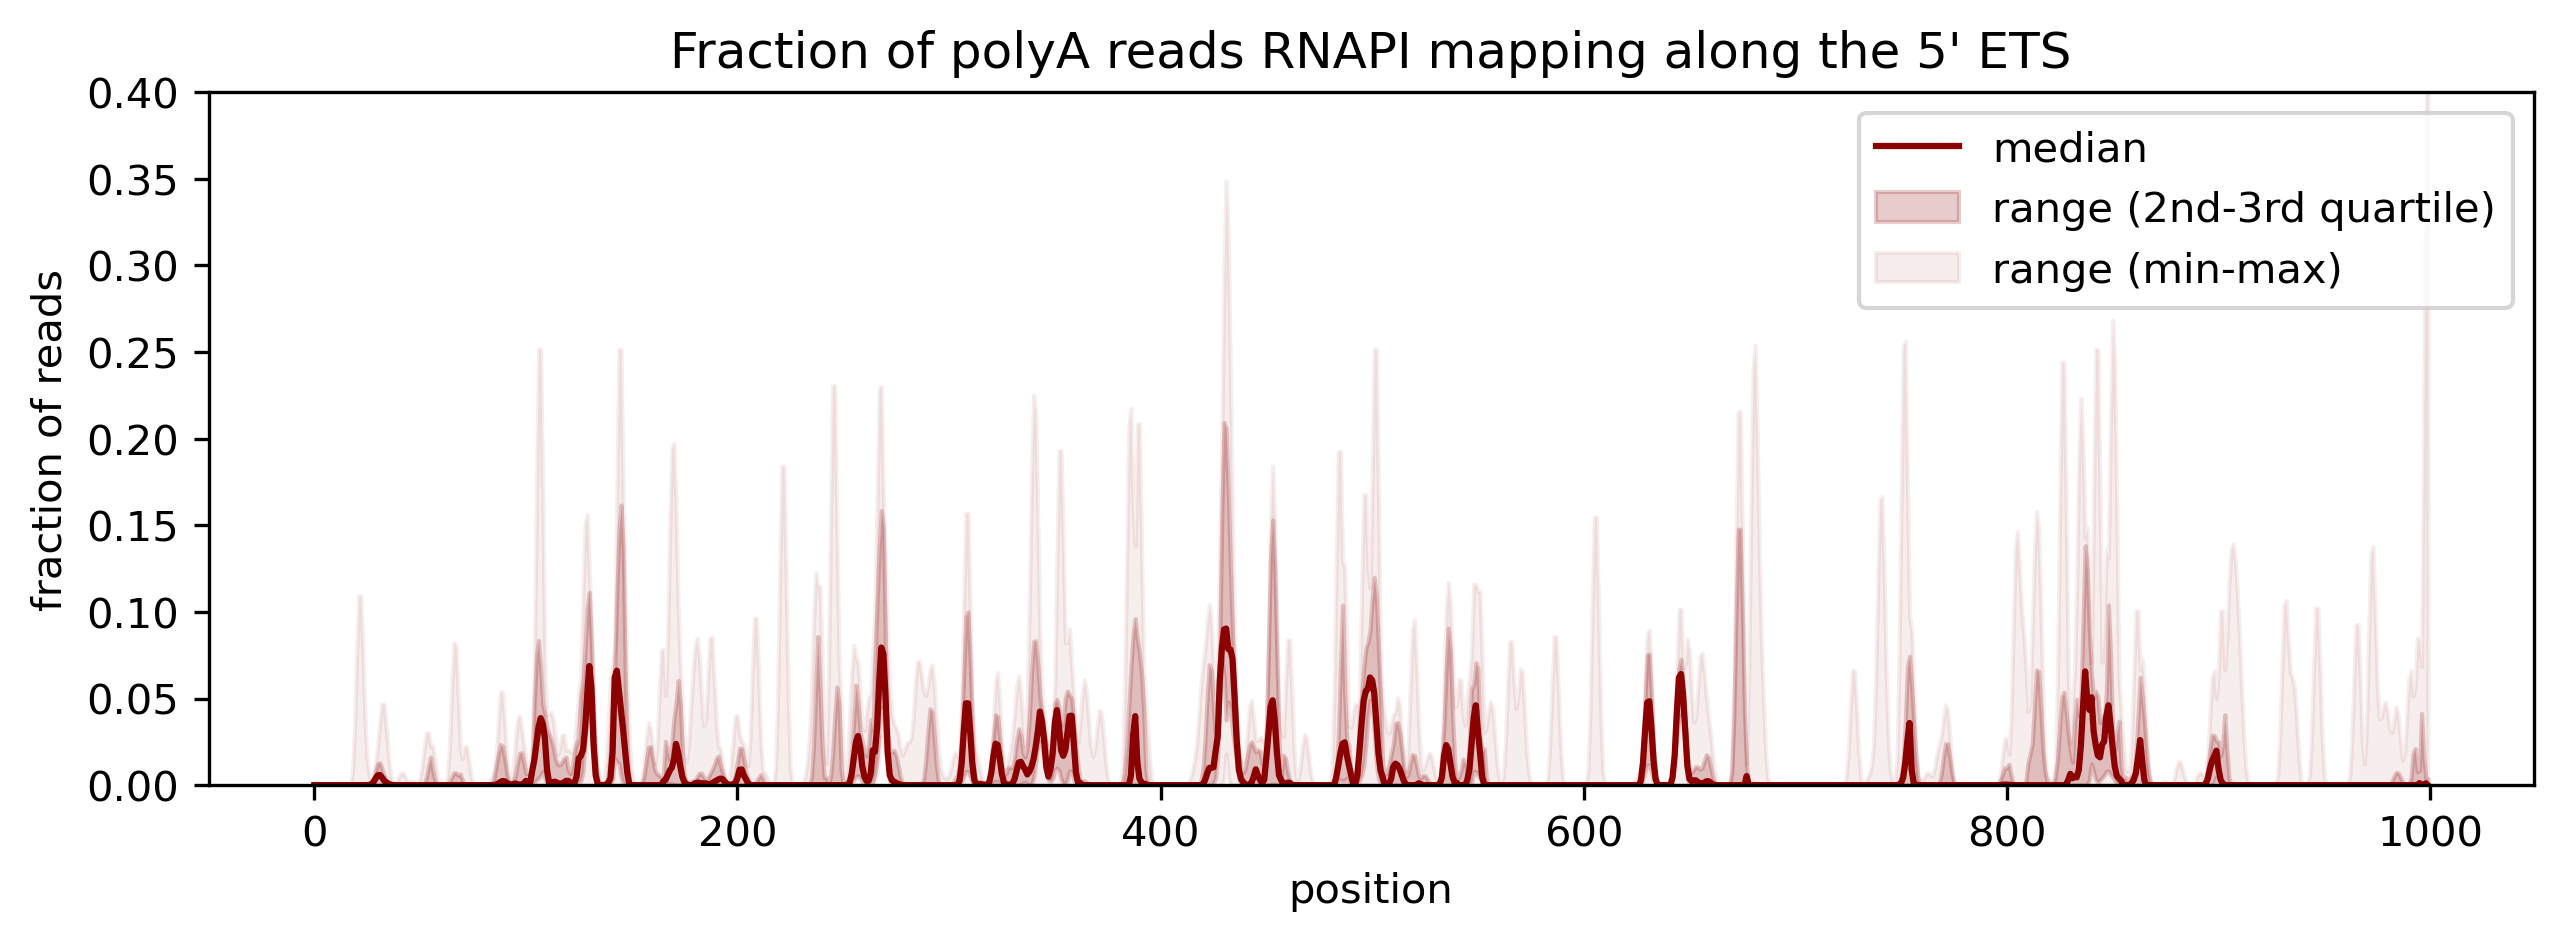

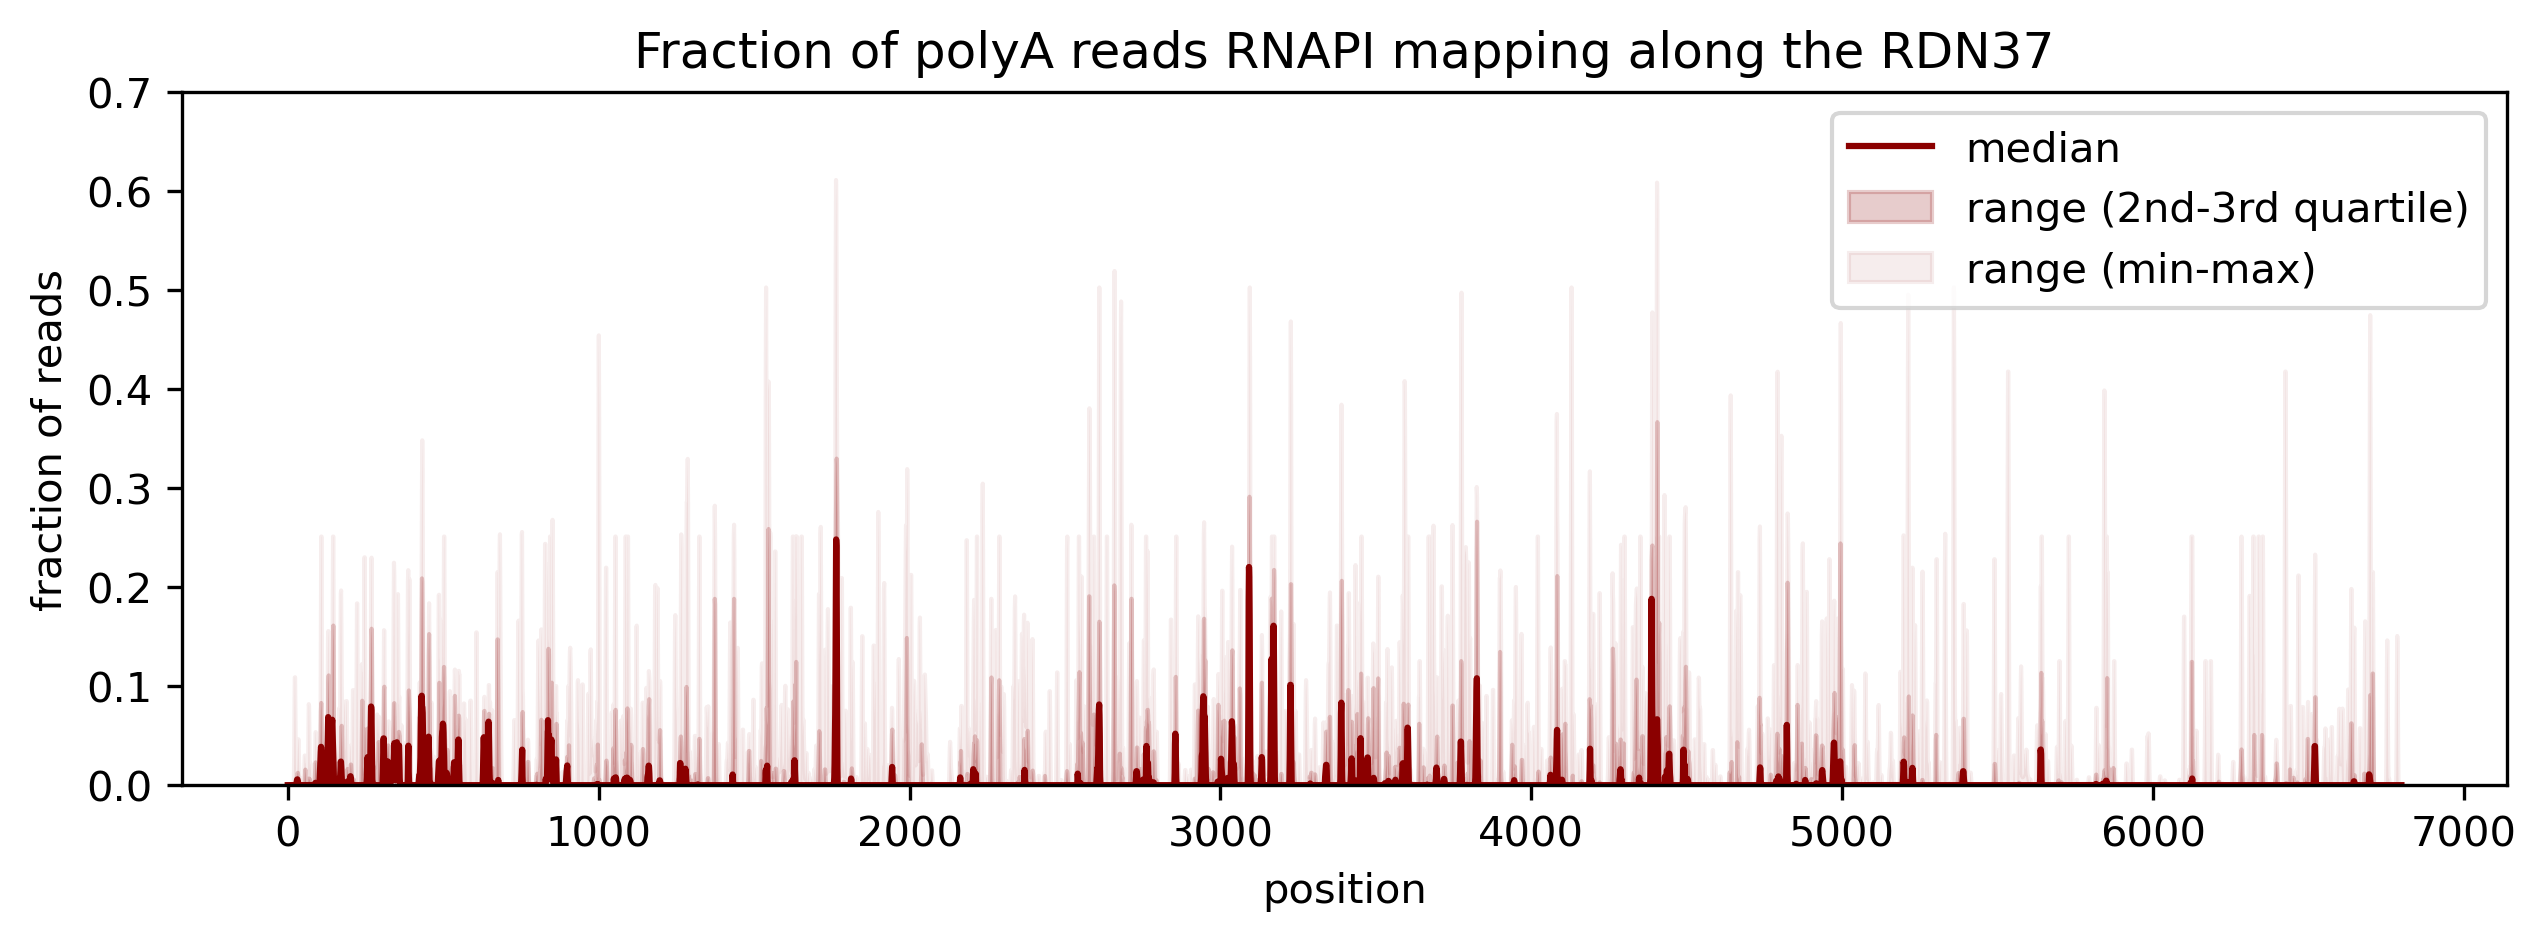

In [5]:
# polyA reads
df14_Rpa190_polyA = polyA_reads(df_raw_all=df01_RDN37_3end, df_raw_polyA=df03_RDN37_polyA,
                                let_in=['Rpa190HTP'],
                                let_out=['hmo1','0s','25rDNA','UVA',
                                         'Rnt1','rrp44','trf4','air1','rat1',
                                         'h_','C_'],
                                         count=False)

tt.plotting.plot_as_box_plot(df14_Rpa190_polyA, title="Fraction of polyA reads RNAPI mapping along the 5' ETS",
                             dpi=300,ylim=(None,0.4), start=0+300, stop=1000+300,color='darkred',figsize=(10,3),
                             offset=300,fname='FIGURES/Fig_4D.png')

tt.plotting.plot_as_box_plot(df14_Rpa190_polyA, title="Fraction of polyA reads RNAPI mapping along the RDN37",
                             dpi=300,ylim=(None,0.7), start=0+300, stop=6800+300,color='darkred',figsize=(10,3),
                             offset=300,fname='FIGURES/Fig_S4C.png')

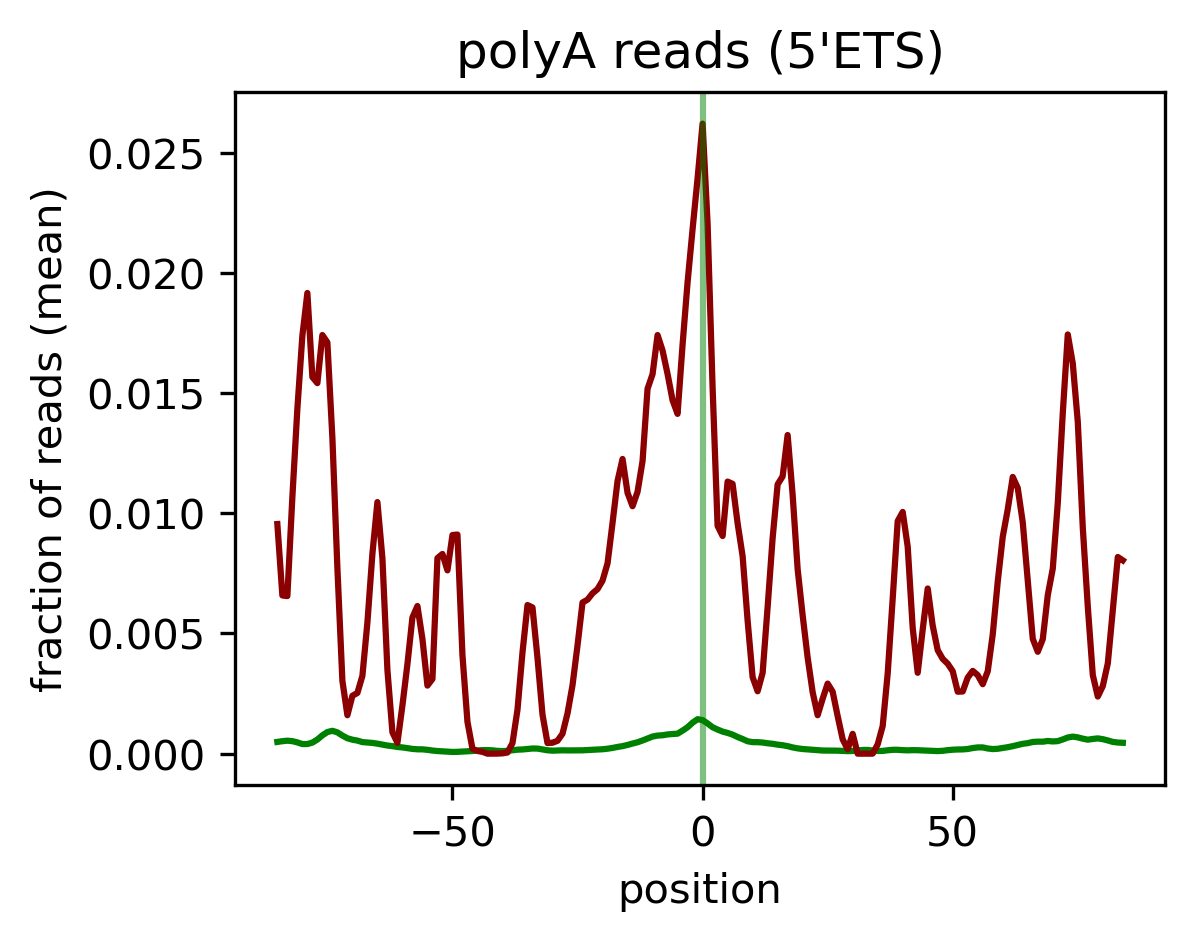

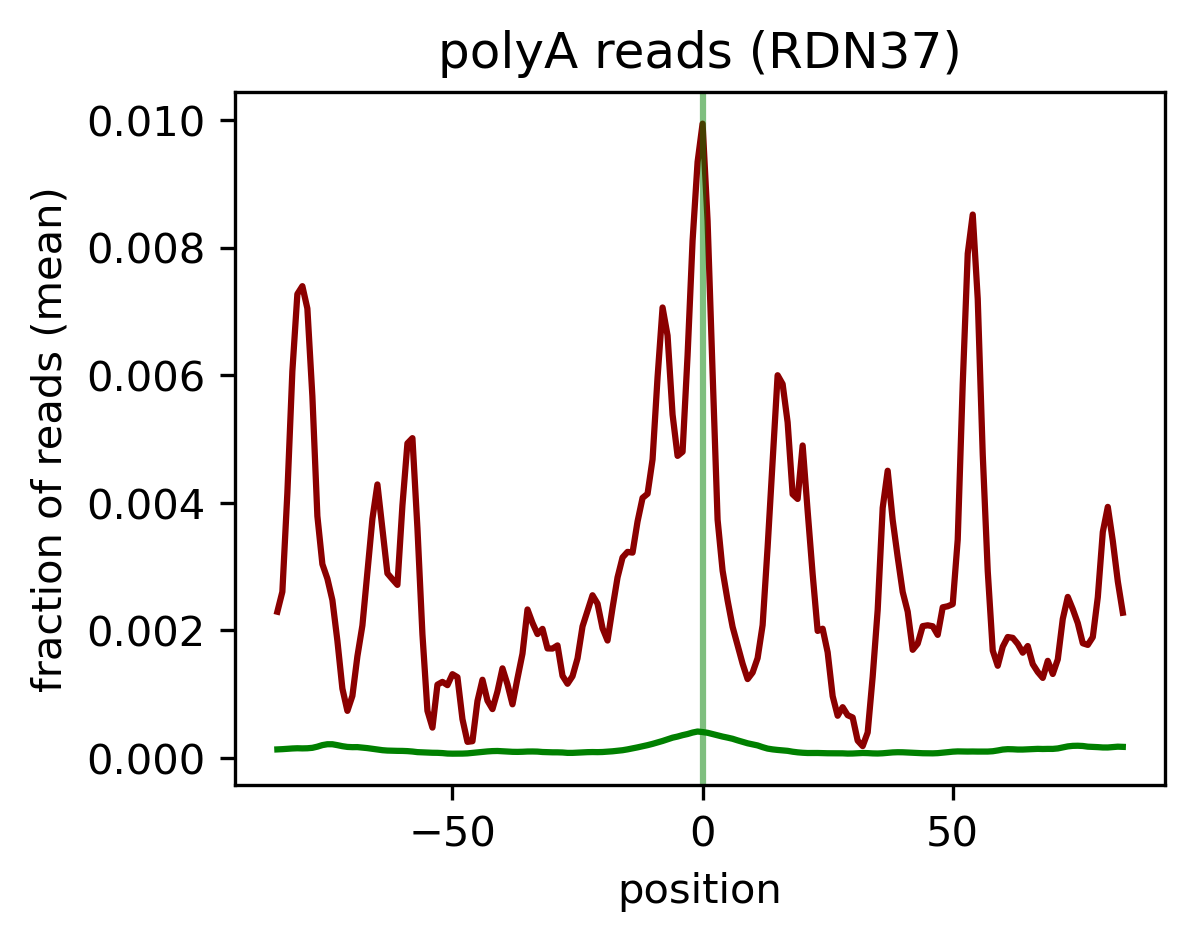

In [6]:
window = 85

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rpa190_polyA, local_pos=peaks, dpi=300,use='mean',
                        title="polyA reads (5'ETS)", start=None, stop=1000, window=window, figsize=(4,3),
                        color1='green', color2="darkred", lc='green',fname="FIGURES/Fig_4E.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df14_Rpa190_polyA, local_pos=peaks, dpi=300,use='mean',
                        title="polyA reads (RDN37)", start=None, stop=7100, window=window, figsize=(4,3),
                        color1='green', color2="darkred", lc='green',fname="FIGURES/Fig_S4D.png")

# trf4 trf5

In [7]:
df31_Rpa190_3end_trf4ts_trf5d_0h = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Rpa190HTP','trf4ts-trf5','25C','seq'], 
                                     let_out=['EP240614', 'seq2' ],stats=True)

df32_Rpa190_3end_trf4ts_trf5d_4h = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Rpa190HTP','trf4ts-trf5','37C','seq'], 
                                     let_out=['EP240614', 'seq2'],stats=True)

# tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df31_Rpa190_3end_trf4ts_trf5d_0h,figsize=(5,2.5),ref_label="wt",label="trf4 trf5∆ (25C)",
#                            title="RNAPI (Rpa190-HTP) mapping along the 5' ETS (wt vs trf4 trf5∆)",
#                            dpi=300,offset=300, ylim=(None,0.01),
#                            start=0+300, stop=700+300,color2='grey',
#                            h_lines=[i-300 for i in cleavage_sites.values()],
#                            fname='Fig_5_unused_trf_25C.png')
 
# tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df32_Rpa190_3end_trf4ts_trf5d_4h,figsize=(5,2.5),ref_label="wt",label="trf4ts-trf5∆ (37C 4h)",
#                            title="RNAPI (Rpa190-HTP) mapping along the 5' ETS (wt vs trf4 trf5∆)",
#                            dpi=300,offset=300, ylim=(None,0.01),
#                            start=0+300, stop=700+300,color2='grey',
#                            h_lines=[i-300 for i in cleavage_sites.values()],
#                            fname='Fig_5_unused_trf_37C.png')

Experiments: 
['seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_2_PROFILE_3end', 'seq9-EP240926_Rpa190HTP_trf4ts-trf5∆_25C_4_PROFILE_3end', 'seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_1_PROFILE_3end']
Experiments: 
['seq9-EP240926_Rpa190HTP_trf4ts-trf5∆_37C-4h_4_PROFILE_3end', 'seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_37C-4h_1_PROFILE_3end', 'seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_37C-4h_2_PROFILE_3end']


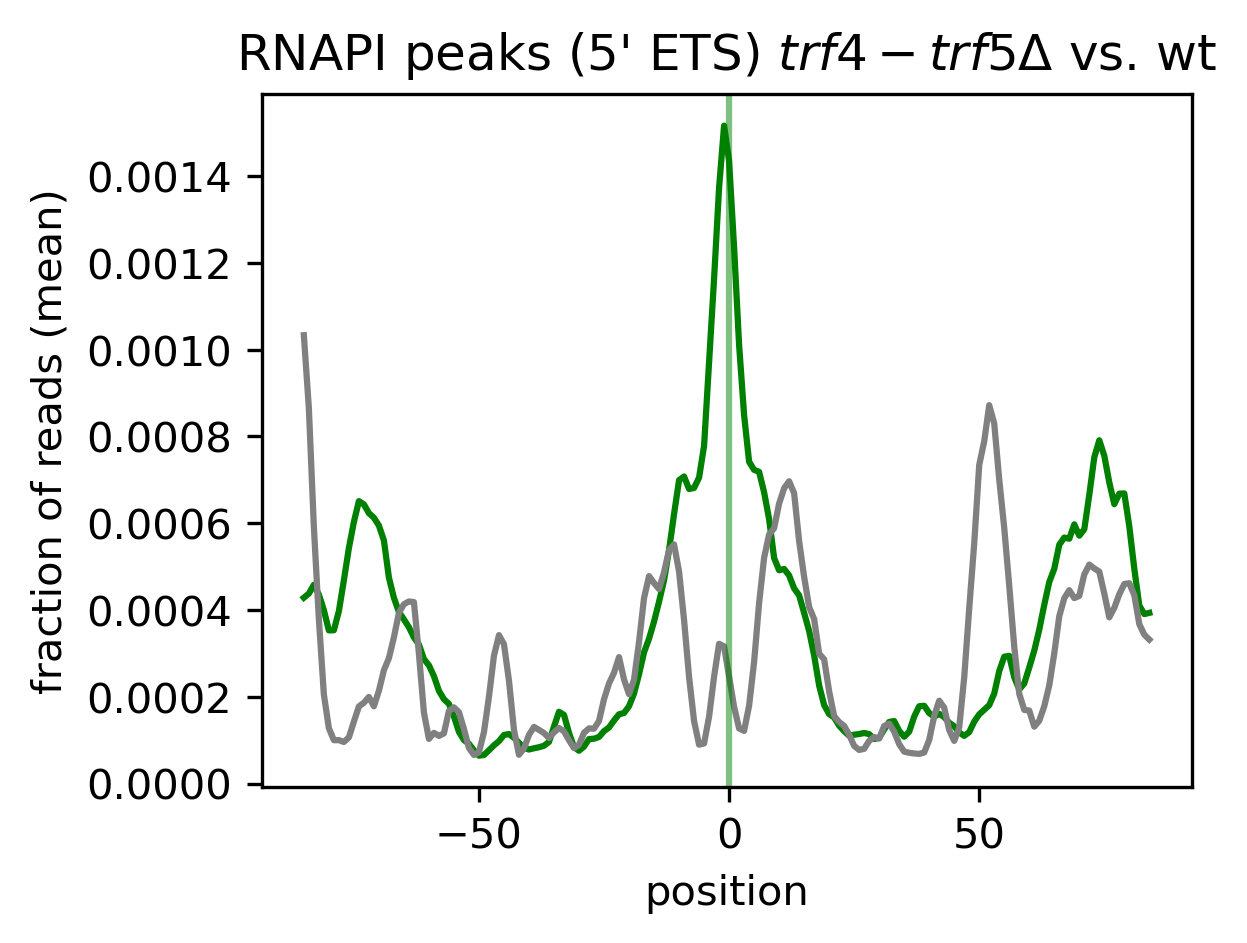

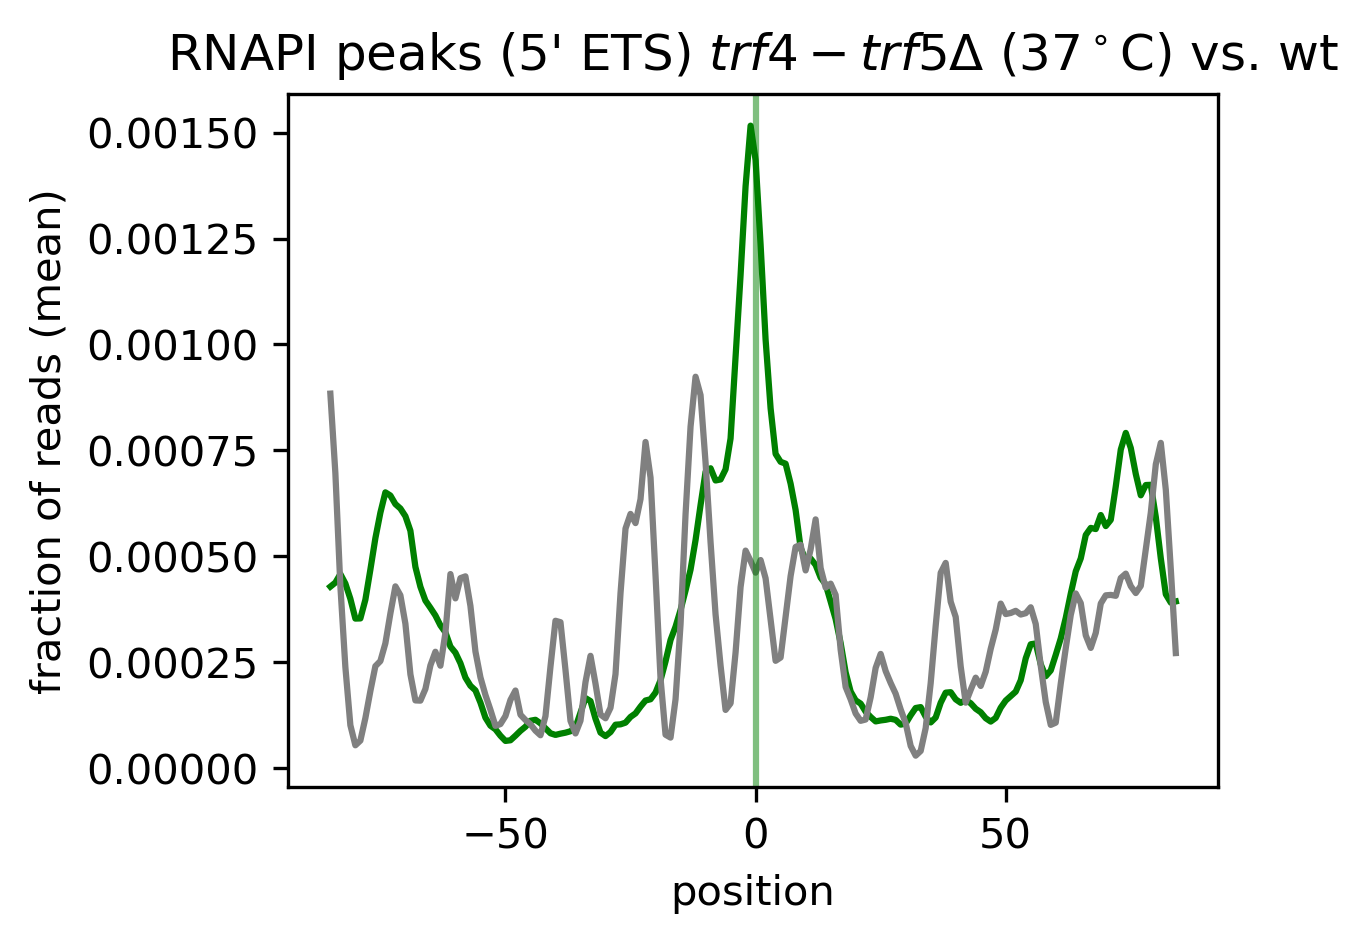

In [8]:
stop=1000
window = 85
elem=" (5' ETS)"

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df31_Rpa190_3end_trf4ts_trf5d_0h, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="RNAPI peaks"+elem+" $\it{trf4-trf5Δ}$ vs. wt", start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="grey", lc='green',fname="FIGURES/Fig_5C.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df32_Rpa190_3end_trf4ts_trf5d_4h, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="RNAPI peaks"+elem+" $\it{trf4-trf5Δ}$ (37$^\circ$C) vs. wt", start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="grey", lc='green',fname="FIGURES/Fig_5C_related_37C_unused.png")

Experiments: 
['seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_2_PROFILE_3end', 'seq9-EP240926_Rpa190HTP_trf4ts-trf5∆_25C_4_PROFILE_3end', 'seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_1_PROFILE_3end']
Experiments: 
['seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_2_PROFILE_3end_polyA', 'seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_1_PROFILE_3end_polyA', 'seq9-EP240926_Rpa190HTP_trf4ts-trf5∆_25C_4_PROFILE_3end_polyA']
Experiments: 
['seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_1_PROFILE_3end', 'seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_2_PROFILE_3end', 'seq9-EP240926_Rpa190HTP_trf4ts-trf5∆_25C_4_PROFILE_3end']
Fraxction of polyA reads in the dataset:
seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_1_PROFILE_3end    0.005812
seq4-EP240606_Rpa190HTP_trf4ts-trf5∆_25C_2_PROFILE_3end    0.003134
seq9-EP240926_Rpa190HTP_trf4ts-trf5∆_25C_4_PROFILE_3end    0.002280
dtype: float64


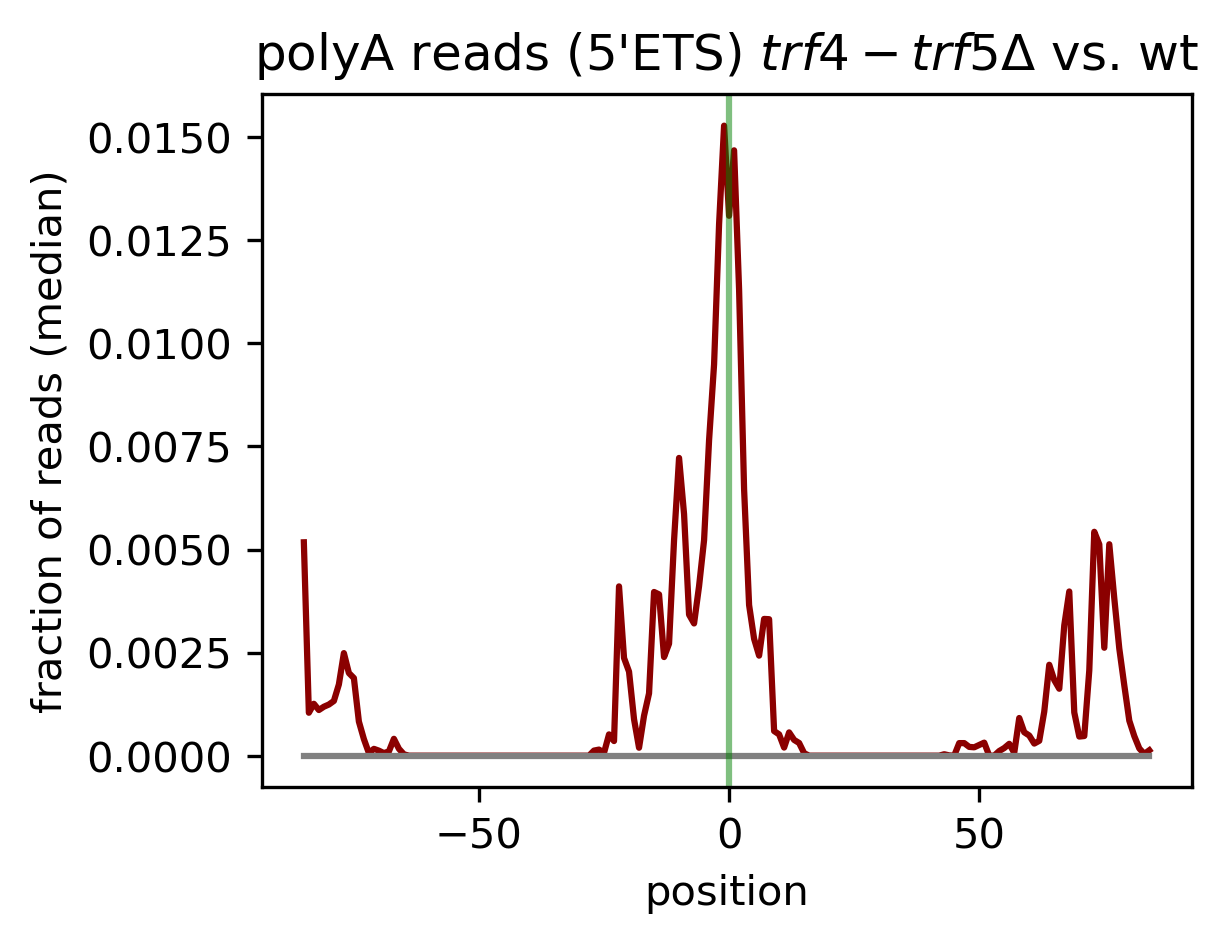

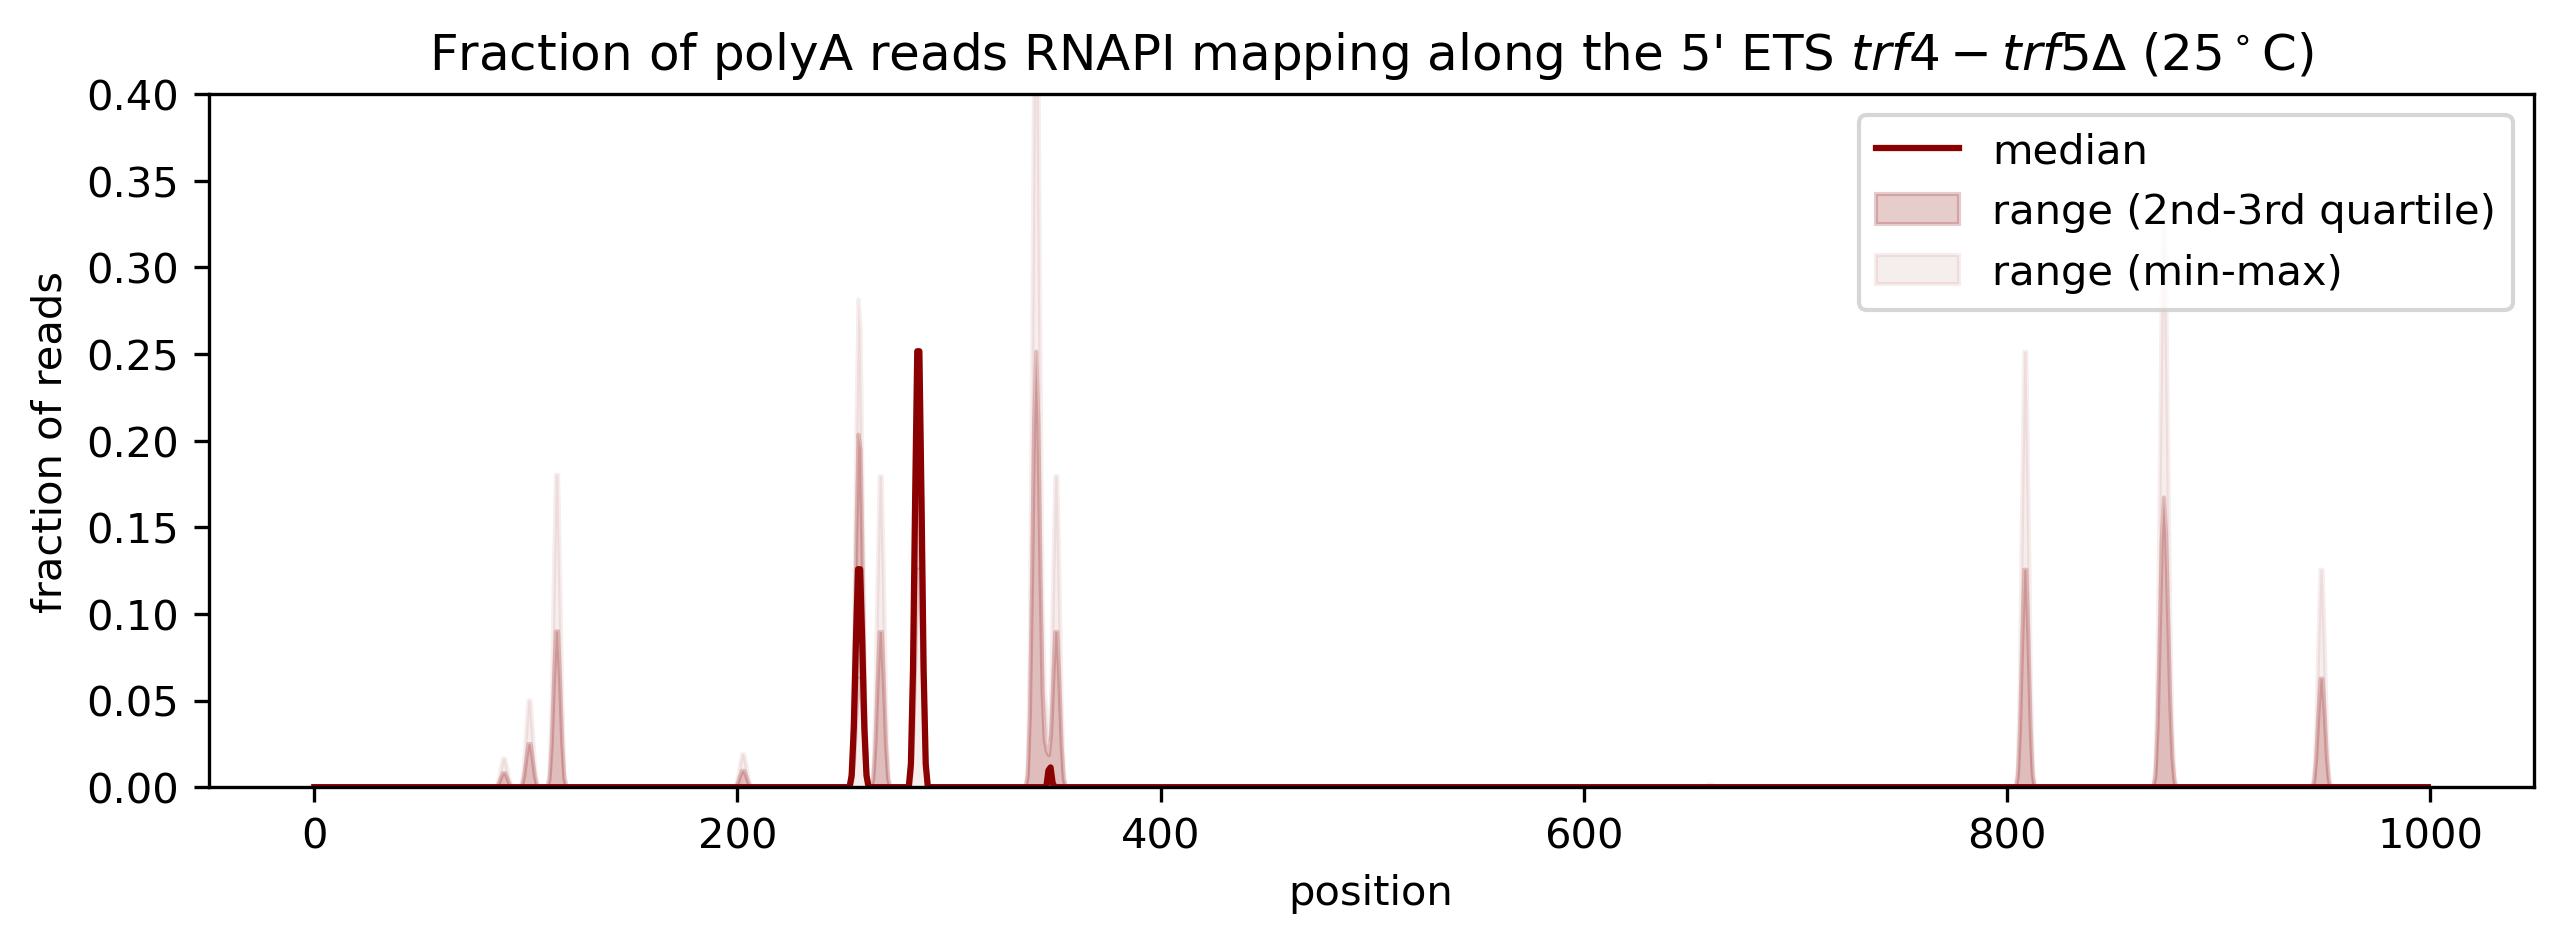

In [9]:
df36_Rpa190_3end_trf4ts_trf5d_0h_polyA = polyA_reads(df_raw_all=df01_RDN37_3end, df_raw_polyA=df03_RDN37_polyA,
                                let_in=['Rpa190HTP','trf4ts-trf5','25C','seq'], let_out=['EP240614','seq2'],
                                         count=False)

window = 85

# tt.plotting.cumulativePeaks(df14_Rpa190_polyA, df2=df36_Rpa190_3end_trf4ts_trf5d_0h_polyA, local_pos=peaks, dpi=300,use='mean',
#                         title="polyA reads (5'ETS) $\it{trf4-trf5Δ}$ vs. wt", start=None, stop=1000, window=window, figsize=(4,3),
#                         color1='darkred', color2="grey", lc='green',fname="Fig_5Gv2_mean.png")

tt.plotting.cumulativePeaks(df14_Rpa190_polyA, df2=df36_Rpa190_3end_trf4ts_trf5d_0h_polyA, local_pos=peaks, dpi=300,use='median',
                        title="polyA reads (5'ETS) $\it{trf4-trf5Δ}$ vs. wt", start=None, stop=1000, window=window, figsize=(4,3),
                        color1='darkred', color2="grey", lc='green',fname="FIGURES/Fig_5E_median.png")

tt.plotting.plot_as_box_plot(df36_Rpa190_3end_trf4ts_trf5d_0h_polyA, 
                             title="Fraction of polyA reads RNAPI mapping along the 5' ETS $\it{trf4-trf5Δ}$ (25$^\circ$C)",
                             dpi=300,ylim=(None,0.4), start=0+300, stop=1000+300,color='darkred',figsize=(10,3),
                             offset=300,fname='FIGURES/Fig_5E_related_unused.png')

# air1 air2

Experiments: 
['seq9-EP240926_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end', 'EP240806_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end']
Experiments: 
['EP240806_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end', 'seq9-EP240926_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end']


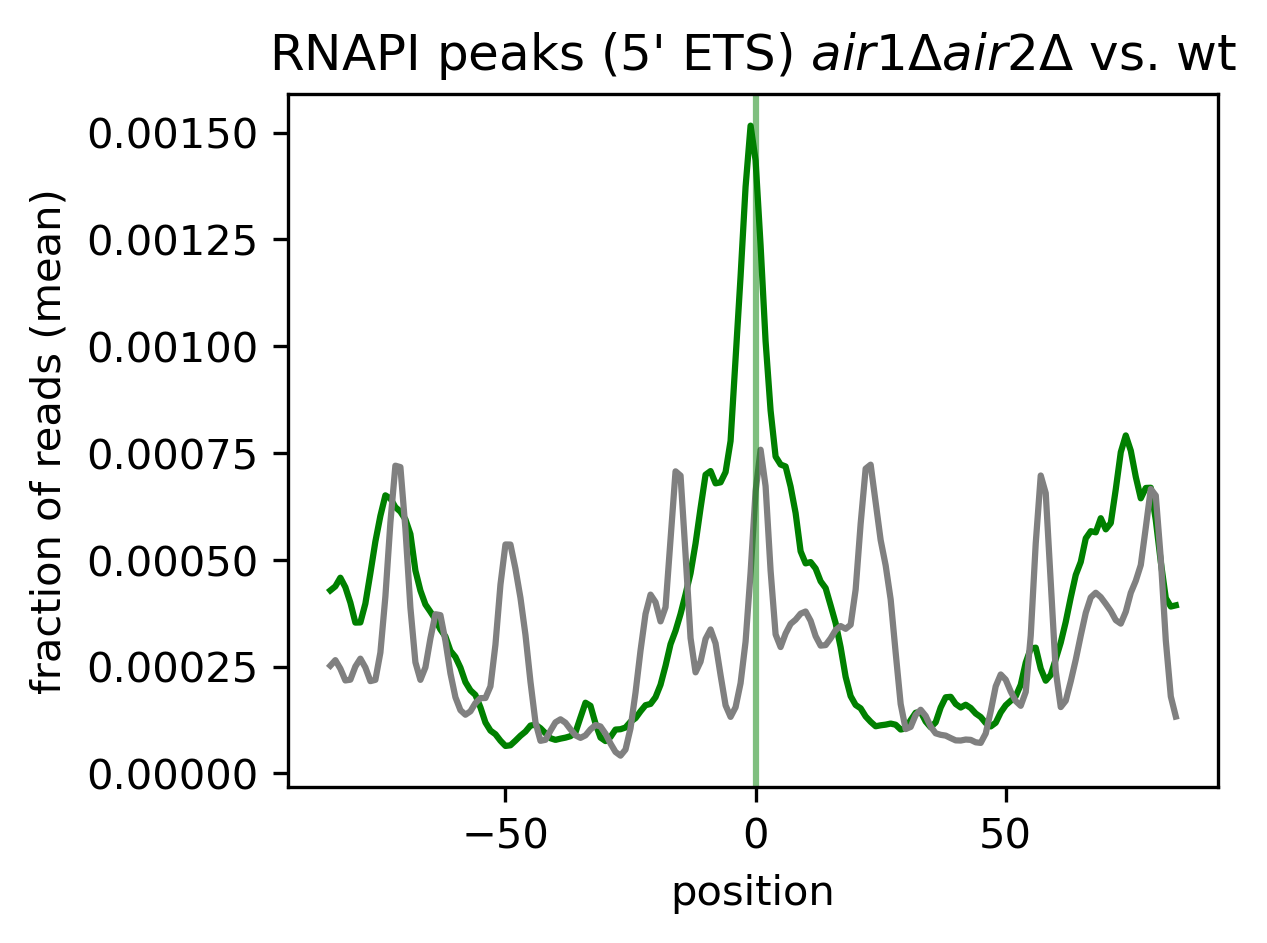

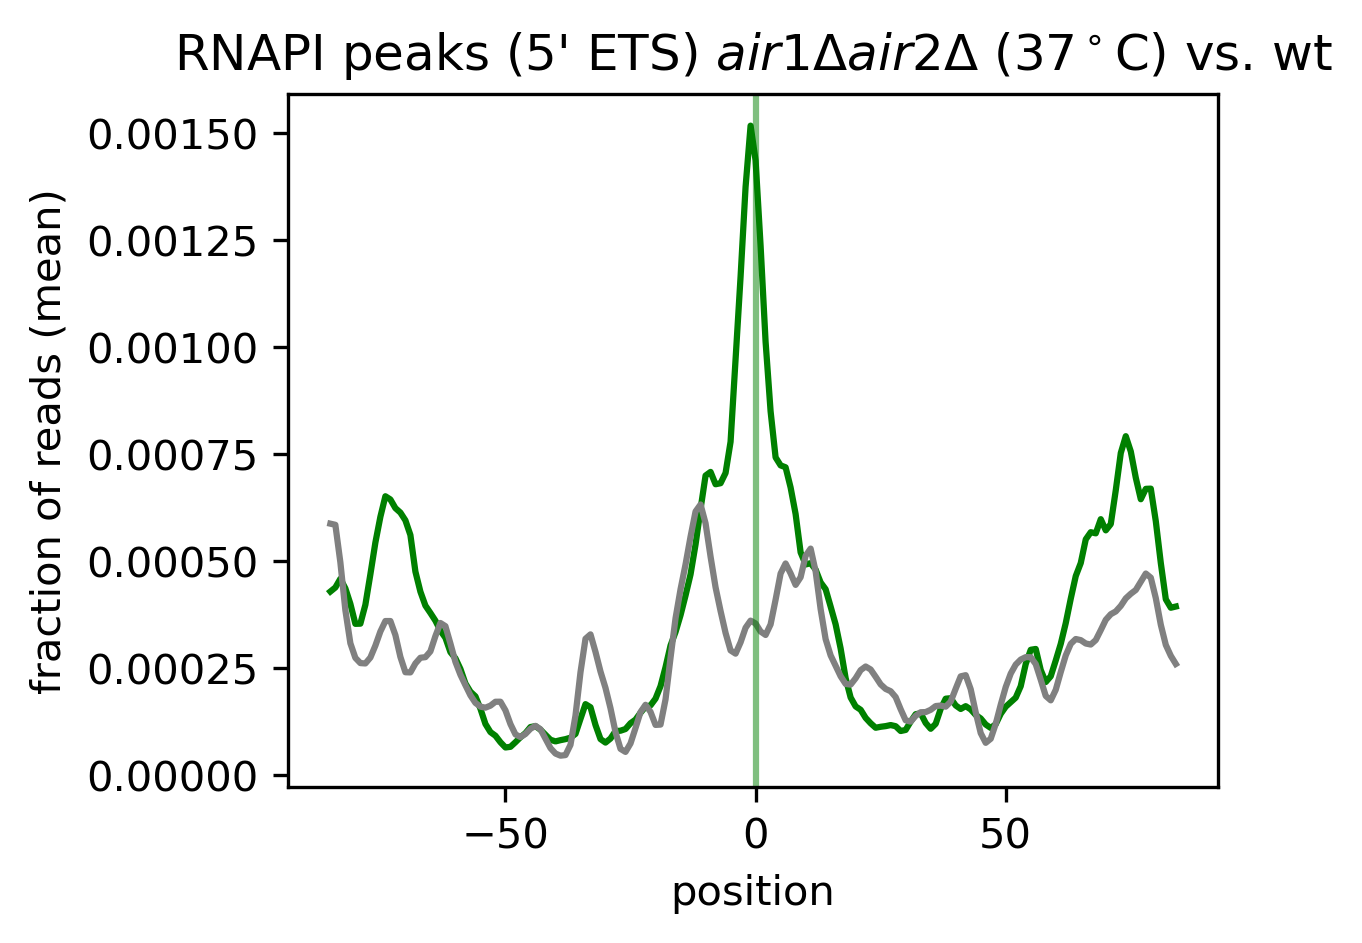

In [10]:
df61_Rpa190_3end_air1d_air2d_0h = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Rpa190HTP','air1','25C'],stats=True)

df62_Rpa190_3end_air1d_air2d_2h = tt.profiles.preprocess(df01_RDN37_3end,
                                     let_in=['Rpa190HTP','air1','37C'],stats=True)

# tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df61_Rpa190_3end_air1d_air2d_0h,figsize=(5,2.5),ref_label="wt",label="air1d-air2d (25C)",
#                            title="RNAPI (Rpa190-HTP) mapping along the 5' ETS (wt vs air1d-air2d)",
#                            dpi=300,offset=300, ylim=(None,0.006),
#                            start=0+300, stop=700+300,
#                            h_lines=[i-300 for i in cleavage_sites.values()],
#                            fname='Fig_5H.png')

# tt.plotting.plot_to_compare(ref=df61_Rpa190_3end_air1d_air2d_0h, df=df62_Rpa190_3end_air1d_air2d_2h,figsize=(5,2.5),ref_label="wt",label="air1d-air2d (37C 2h)",
#                            title="RNAPI (Rpa190-HTP) mapping along the 5' ETS (wt vs air1d-air2d)",
#                            dpi=300,offset=300, ylim=(None,0.006),
#                            start=0+300, stop=700+300,
#                            h_lines=[i-300 for i in cleavage_sites.values()],
#                            fname='Fig_S5G.png')

stop=1000
window = 85
elem=" (5' ETS)"

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df61_Rpa190_3end_air1d_air2d_0h, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="RNAPI peaks"+elem+" $\it{air1Δ air2Δ}$ vs. wt", start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="grey", lc='green',fname="FIGURES/Fig_5D.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df62_Rpa190_3end_air1d_air2d_2h, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="RNAPI peaks"+elem+" $\it{air1Δ air2Δ}$ (37$^\circ$C) vs. wt", start=None, stop=stop, window=window, figsize=(4,3),
                        color1='green', color2="grey", lc='green',fname="FIGURES/Fig_5D_related_37C_unused.png")

Experiments: 
['seq9-EP240926_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end', 'EP240806_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end']
Experiments: 
['seq9-EP240926_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end_polyA', 'EP240806_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end_polyA']
Experiments: 
['seq9-EP240926_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end', 'EP240806_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end']
Fraxction of polyA reads in the dataset:
seq9-EP240926_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end    0.002372
EP240806_Rpa190HTP_air1d-air2d_25C_1_PROFILE_3end         0.004884
dtype: float64
Experiments: 
['EP240806_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end', 'seq9-EP240926_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end']
Experiments: 
['seq9-EP240926_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end_polyA', 'EP240806_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end_polyA']
Experiments: 
['EP240806_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end', 'seq9-EP240926_Rpa190HTP_air1d-air2d_37C-2h_2_PROFILE_3end']
Fraxction of

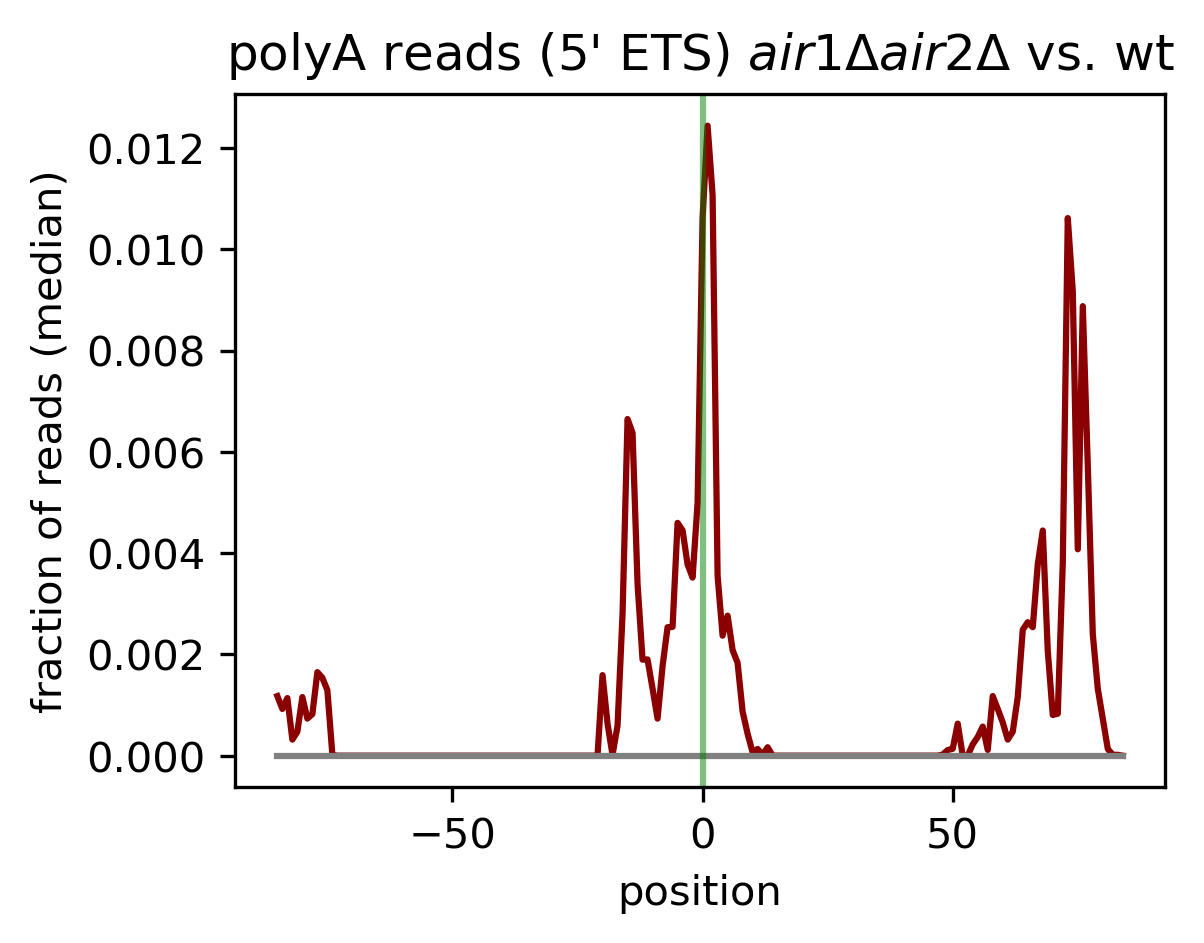

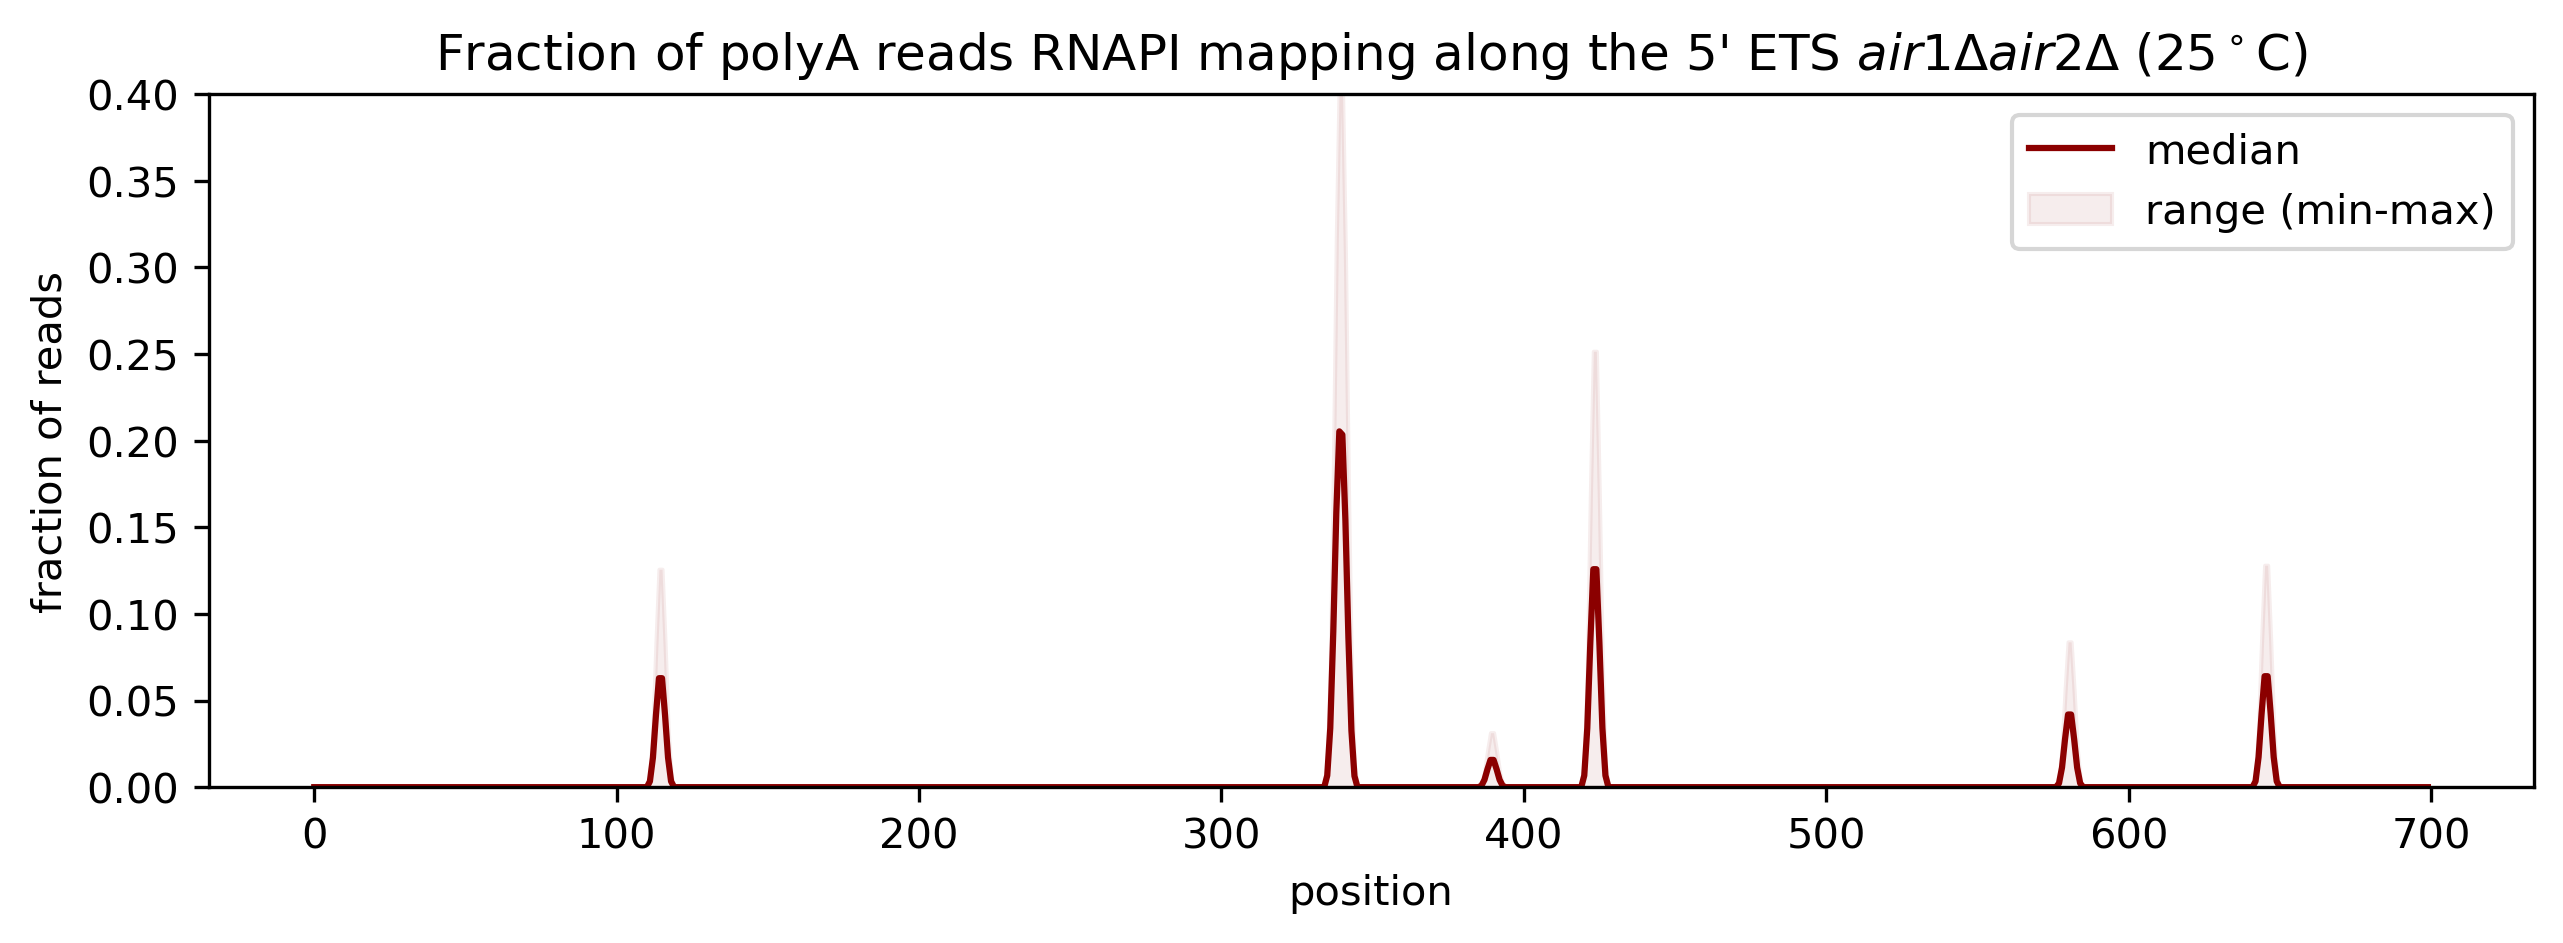

In [11]:
df63_Rpa190_3end_air1d_air2d_0h_polyA = polyA_reads(df_raw_all=df01_RDN37_3end, df_raw_polyA=df03_RDN37_polyA,
                                let_in=['Rpa190HTP','air1','25C'], count=False)

df64_Rpa190_3end_air1d_air2d_2h_polyA = polyA_reads(df_raw_all=df01_RDN37_3end, df_raw_polyA=df03_RDN37_polyA,
                                let_in=['Rpa190HTP','air1','37C'], count=False)


stop=1000
window = 85

tt.plotting.cumulativePeaks(df14_Rpa190_polyA, df2=df63_Rpa190_3end_air1d_air2d_0h_polyA, local_pos=[i for i in peaks if i != 643], dpi=300,
                        title="polyA reads"+elem+" $\it{air1Δ air2Δ}$ vs. wt", start=None, stop=stop, window=window, figsize=(4,3),
                        color1='darkred', color2="grey", lc='green',fname="FIGURES/Fig_5F.png", use='median')

tt.plotting.plot_as_box_plot(df63_Rpa190_3end_air1d_air2d_0h_polyA, title="Fraction of polyA reads RNAPI mapping along the 5' ETS $\it{air1Δ air2Δ}$ (25$^\circ$C)",
                             dpi=300,ylim=(None,0.4), start=0+300, stop=700+300,color='darkred',figsize=(10,3),
                             offset=300,fname='FIGURES/Fig_5F_related_unused.png')



# Rpa135 wt and Rpa12dC

Experiments: 
['EP240614_Rpa135HTP_wt_none_1_PROFILE_3end', 'LP230802_Rpa135HTP_wt_none_1b_PROFILE_3end', 'seq3-EP240614_Rpa135HTP_wt_none_1_PROFILE_3end', 'LP221214_Rpa135HTP_wt_none_2_PROFILE_3end', 'EP190925_Rpa135HTP_wt_none_3_PROFILE_3end', 'C23P2-TT181022_Rpa135HTP_wt_none_2_PROFILE_3end', 'LP230802_Rpa135HTP_wt_none_1a_PROFILE_3end', 'LP230405_Rpa135HTP_wt_none_1_PROFILE_3end']
Experiments: 
['EP190925_Rpa135HTP_wt_none_3_PROFILE_3end_polyA', 'LP230802_Rpa135HTP_wt_none_1b_PROFILE_3end_polyA', 'LP230405_Rpa135HTP_wt_none_1_PROFILE_3end_polyA', 'seq3-EP240614_Rpa135HTP_wt_none_1_PROFILE_3end_polyA', 'LP230802_Rpa135HTP_wt_none_1a_PROFILE_3end_polyA', 'C23P2-TT181022_Rpa135HTP_wt_none_2_PROFILE_3end_polyA', 'LP221214_Rpa135HTP_wt_none_2_PROFILE_3end_polyA', 'EP240614_Rpa135HTP_wt_none_1_PROFILE_3end_polyA']
Experiments: 
['LP230802_Rpa135HTP_Rpa12dC-nsi1d_none_2b_PROFILE_3end', 'C23P2-TT181022_Rpa135HTP_Rpa12dC_none_1_PROFILE_3end', 'LP230405_Rpa135HTP_Rpa12dC_none_1_PROFILE_3end'

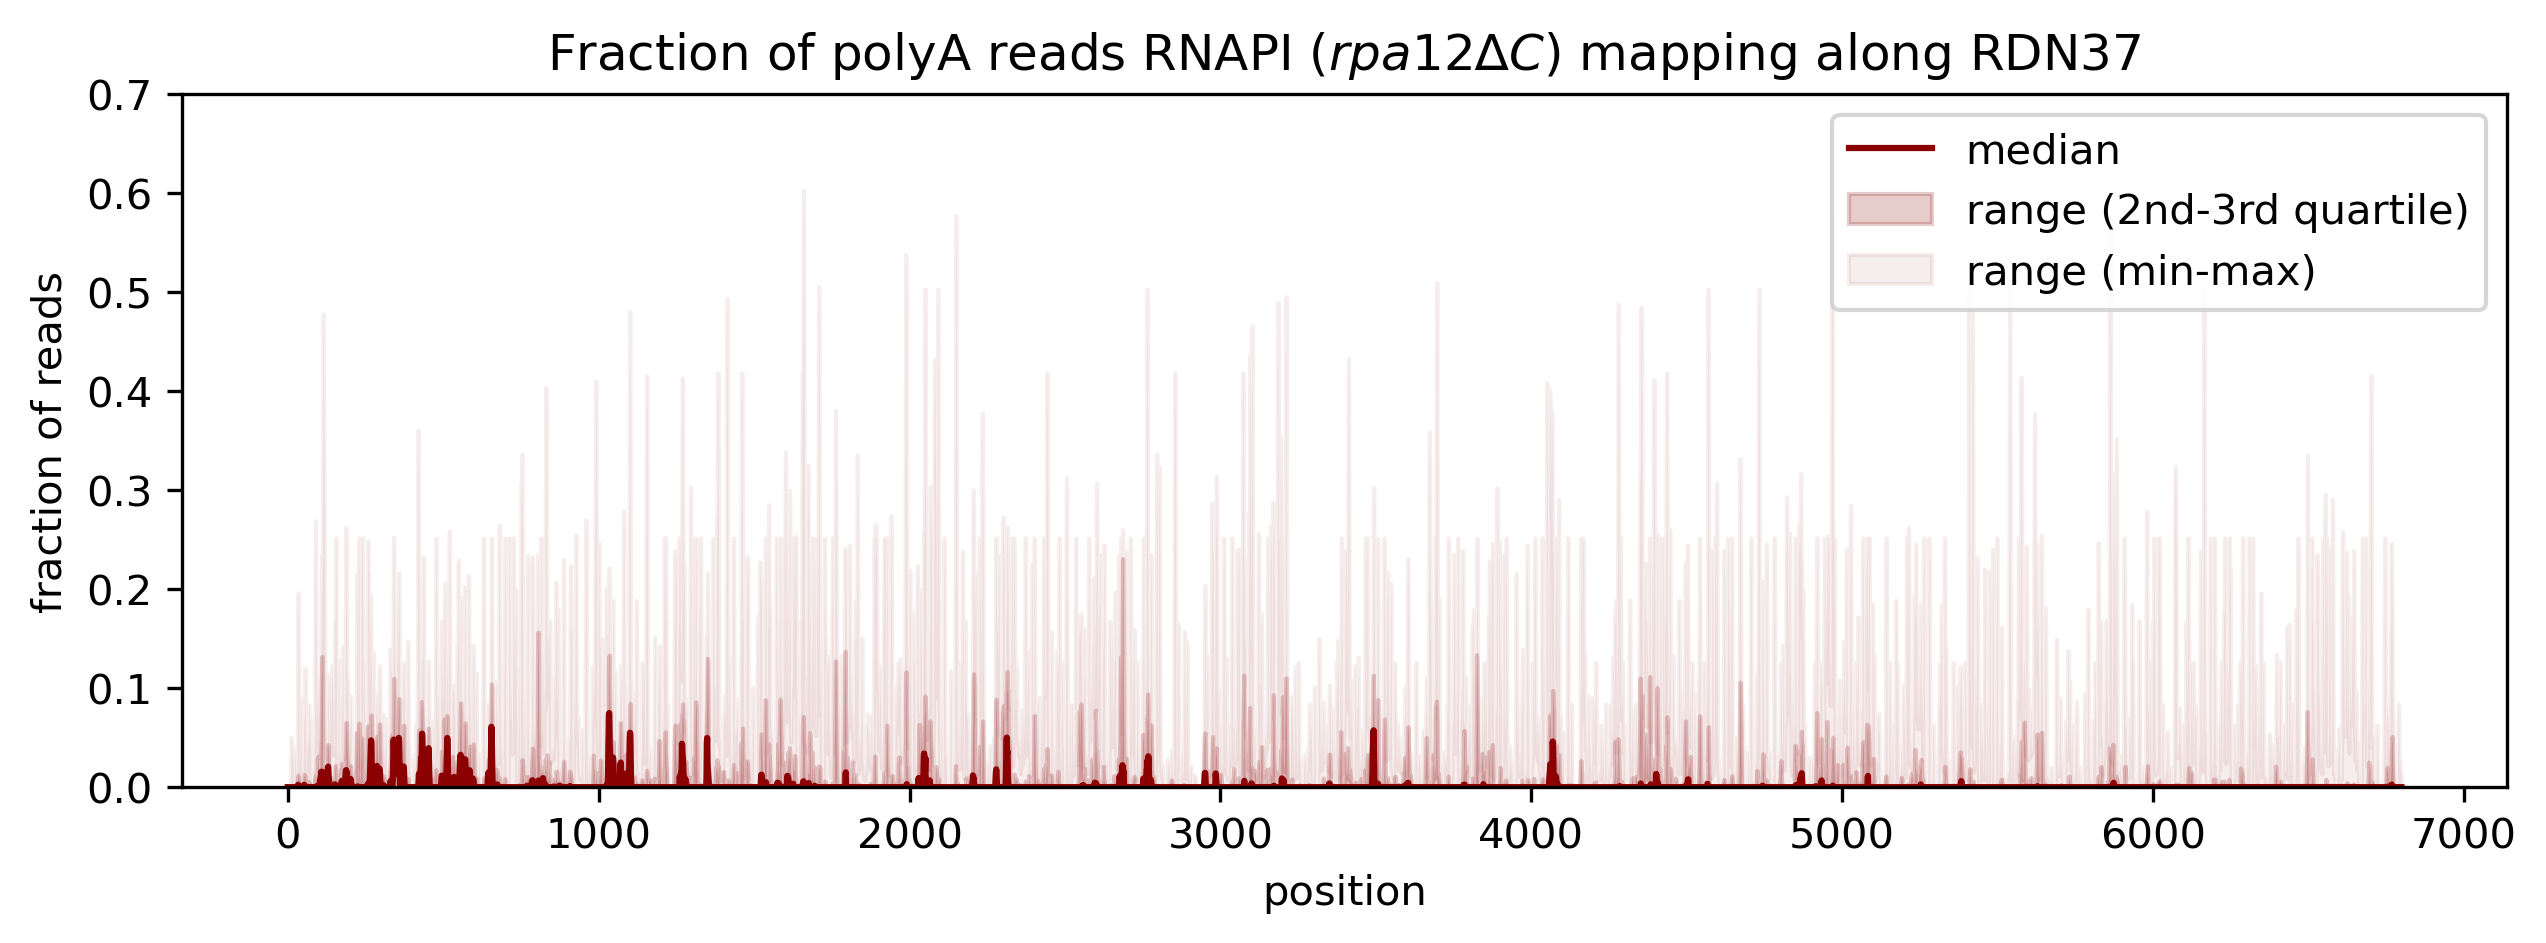

In [12]:
df41_Rpa135_3end = tt.profiles.preprocess(df01_RDN37_3end,let_in=['Rpa135HTP_wt'], 
                                     let_out=["noUV",'C18','C20'],stats=False, 
                                     smooth=False,pseudocounts_param=False, ntotal_param=False)

df42_Rpa135_3end_polyA = tt.profiles.preprocess(df03_RDN37_polyA,let_in=['Rpa135HTP_wt'], 
                                     let_out=["noUV",'C18','C20'],stats=False,
                                     smooth=False,pseudocounts_param=False, ntotal_param=False)

df51_Rpa135_Rpa12dC_3end = tt.profiles.preprocess(df01_RDN37_3end,let_in=['Rpa135HTP_Rpa12dC'], 
                                     let_out=["noUV",'C18','C20'],stats=False, 
                                     smooth=False,pseudocounts_param=False, ntotal_param=False)

df52_Rpa135_Rpa12dC_3end_polyA = tt.profiles.preprocess(df03_RDN37_polyA,let_in=['Rpa135HTP_Rpa12dC'], 
                                     let_out=["noUV",'C18','C20'],stats=False,
                                     smooth=False,pseudocounts_param=False, ntotal_param=False)

df42_Rpa135_3end_polyA.columns = [i.replace("_polyA","") for i in df42_Rpa135_3end_polyA.columns]
df43_Rpa135_fractionPolyA = df42_Rpa135_3end_polyA / df41_Rpa135_3end

df52_Rpa135_Rpa12dC_3end_polyA.columns = [i.replace("_polyA","") for i in df52_Rpa135_Rpa12dC_3end_polyA.columns]
df53_Rpa135_Rpa12dC_fractionPolyA = df52_Rpa135_Rpa12dC_3end_polyA / df51_Rpa135_Rpa12dC_3end

df44_polyA = tt.profiles.preprocess(df43_Rpa135_fractionPolyA.fillna(0.0),let_in=['Rpa135HTP_wt'],
                                     let_out=["noUV",'C18','C20'],stats=True,
                                     smooth=True,pseudocounts_param=False, ntotal_param=False)

df54_Rpa12dC_polyA = tt.profiles.preprocess(df53_Rpa135_Rpa12dC_fractionPolyA.fillna(0.0),let_in=['Rpa135HTP_Rpa12dC'],
                                     let_out=["noUV",'C18','C20'],stats=True,
                                     smooth=True,pseudocounts_param=False, ntotal_param=False)

# tt.plotting.plot_as_box_plot(df44_polyA, title="Fraction of polyA reads RNAPI (wt) mapping along RDN37",
#                              dpi=300,ylim=(None,0.7), start=0+300, stop=6800+300,color='darkred',figsize=(10,3),
#                              offset=300,fname='Fig_S4C_polyA_wt.png')

tt.plotting.plot_as_box_plot(df54_Rpa12dC_polyA, title="Fraction of polyA reads RNAPI ($\it{rpa12∆C}$) mapping along RDN37",
                             dpi=300,ylim=(None,0.7), start=0+300, stop=6800+300,color='darkred',figsize=(10,3),
                             offset=300,fname='FIGURES/Fig_S4C_related_polyA_a12dC_unused.png')

# Top2

Experiments: 
['26A_MW160713_Top2HTP_wt_raw', '26A_mix2_MW160713_Top2HTP_wt_raw', '26A_mix1_MW160713_Top2HTP_wt_raw', '26B_MW160713_Top2HTP_wt_raw', '11B_MW151027_Top2HTP_wt_raw']


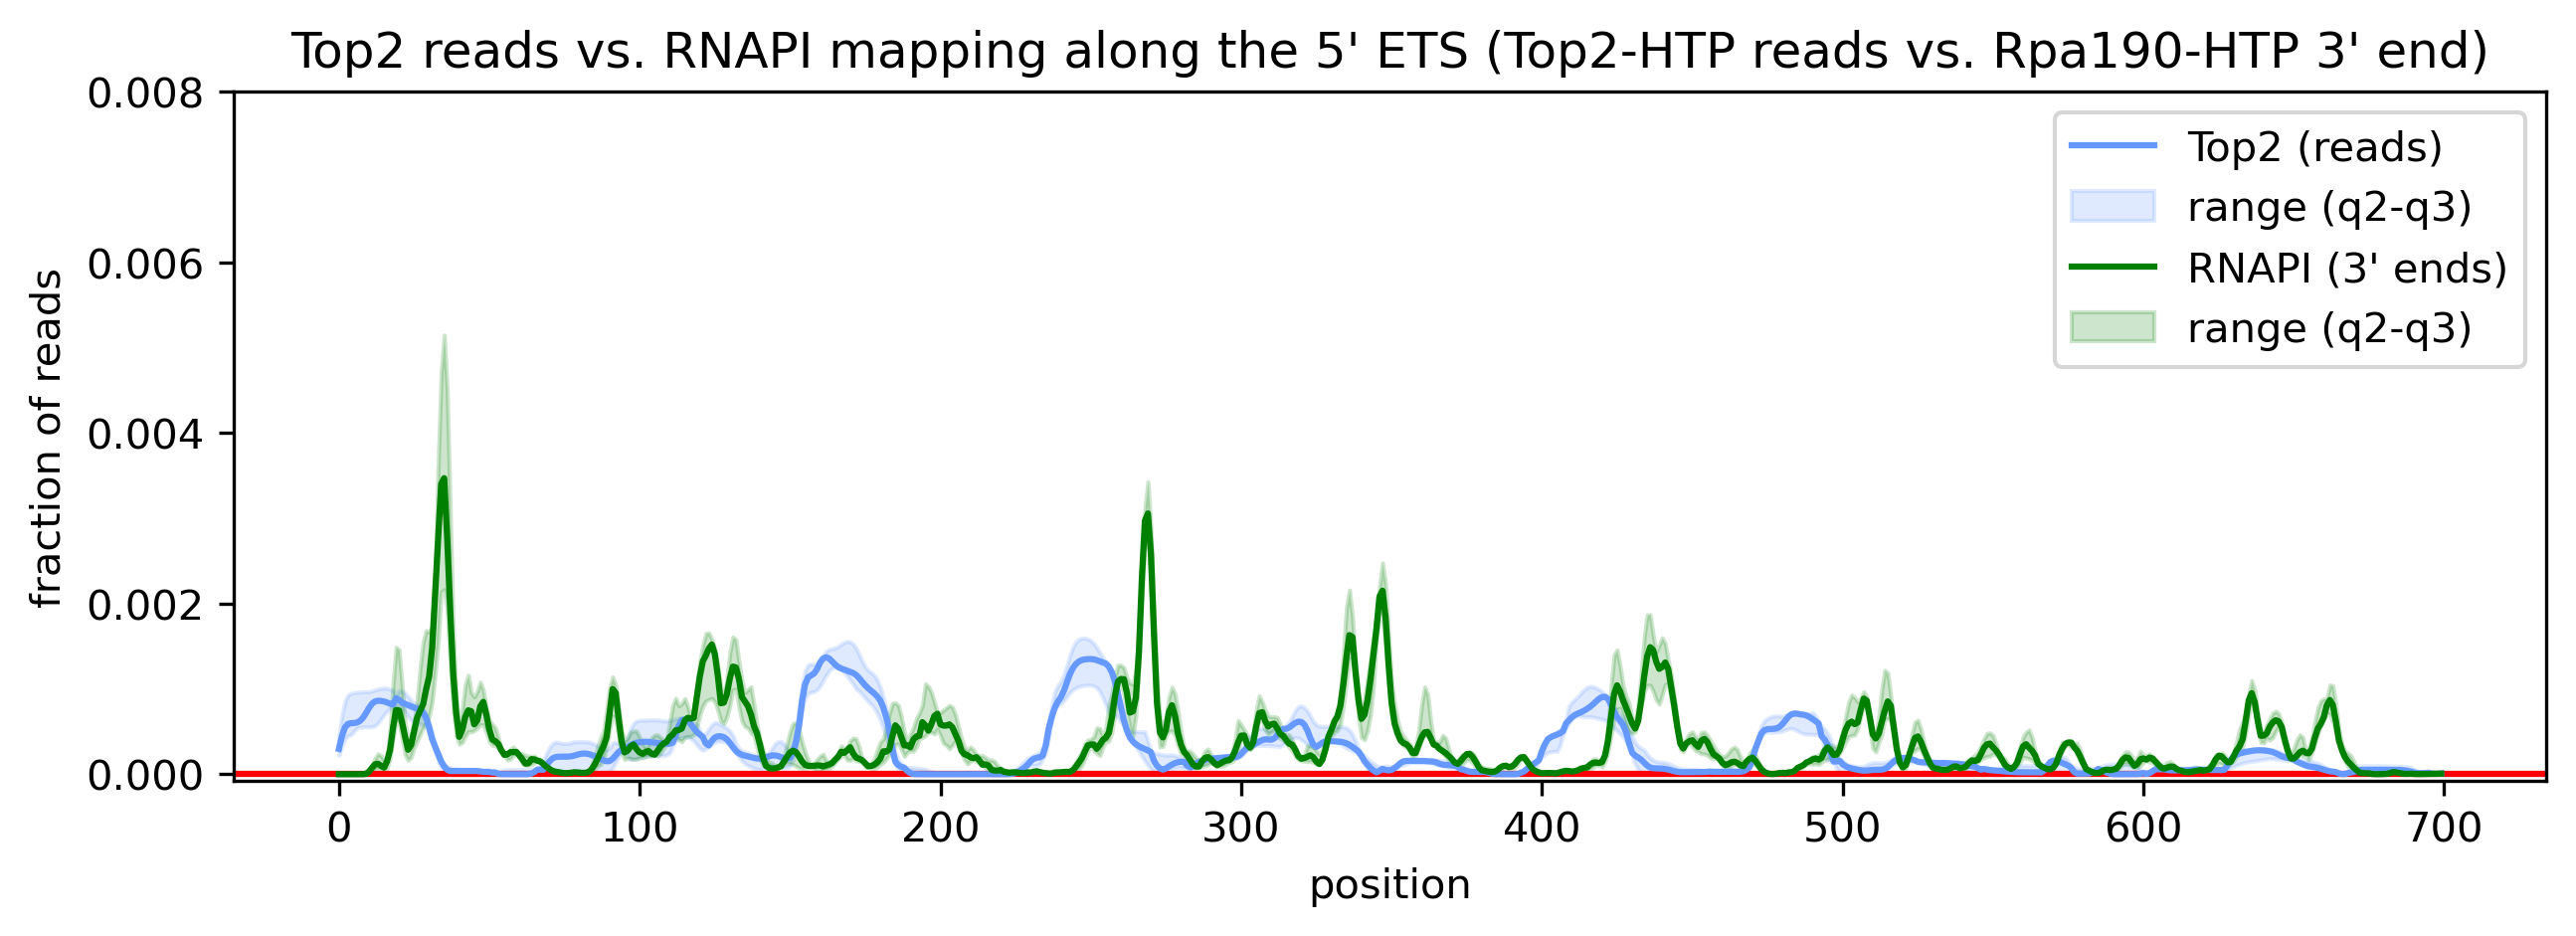

In [13]:
df72_Top2_reads = tt.profiles.preprocess(df04_RDN37_raw,
                                     let_in=['Top2'], 
                                     let_out=['hmo1','0s','25rDNA','UVA',
                                         'Rnt1','rrp44','trf4','air1','rat1',
                                         'h_','C_'],stats=True)

tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df72_Top2_reads,figsize=(10,3),ref_label="RNAPI (3' ends)",label="Top2 (reads)",
                           title="Top2 reads vs. RNAPI mapping along the 5' ETS (Top2-HTP reads vs. Rpa190-HTP 3' end)",
                           dpi=300,offset=300, ylim=(None,0.008),color2='#6699FF',
                           start=0+300, stop=700+300,
                           fname='FIGURES/Fig_5H_Top2_reads.png')


Experiments: 
['11B_MW151027_Top2HTP_wt_PROFILE_3end', '26A_MW160713_Top2HTP_wt_PROFILE_3end', '26A_mix1_MW160713_Top2HTP_wt_PROFILE_3end', '26B_MW160713_Top2HTP_wt_PROFILE_3end', '26A_mix2_MW160713_Top2HTP_wt_PROFILE_3end']
Experiments: 
['26A_mix1_MW160713_Top2HTP_wt_PROFILE_3end_polyA', '26B_MW160713_Top2HTP_wt_PROFILE_3end_polyA', '26A_mix2_MW160713_Top2HTP_wt_PROFILE_3end_polyA', '26A_MW160713_Top2HTP_wt_PROFILE_3end_polyA', '11B_MW151027_Top2HTP_wt_PROFILE_3end_polyA']
Experiments: 
['11B_MW151027_Top2HTP_wt_PROFILE_3end', '26A_MW160713_Top2HTP_wt_PROFILE_3end', '26A_mix1_MW160713_Top2HTP_wt_PROFILE_3end', '26A_mix2_MW160713_Top2HTP_wt_PROFILE_3end', '26B_MW160713_Top2HTP_wt_PROFILE_3end']
Fraxction of polyA reads in the dataset:
11B_MW151027_Top2HTP_wt_PROFILE_3end         0.075245
26A_MW160713_Top2HTP_wt_PROFILE_3end         0.145975
26A_mix1_MW160713_Top2HTP_wt_PROFILE_3end    0.153357
26A_mix2_MW160713_Top2HTP_wt_PROFILE_3end    0.098796
26B_MW160713_Top2HTP_wt_PROFILE_3end  

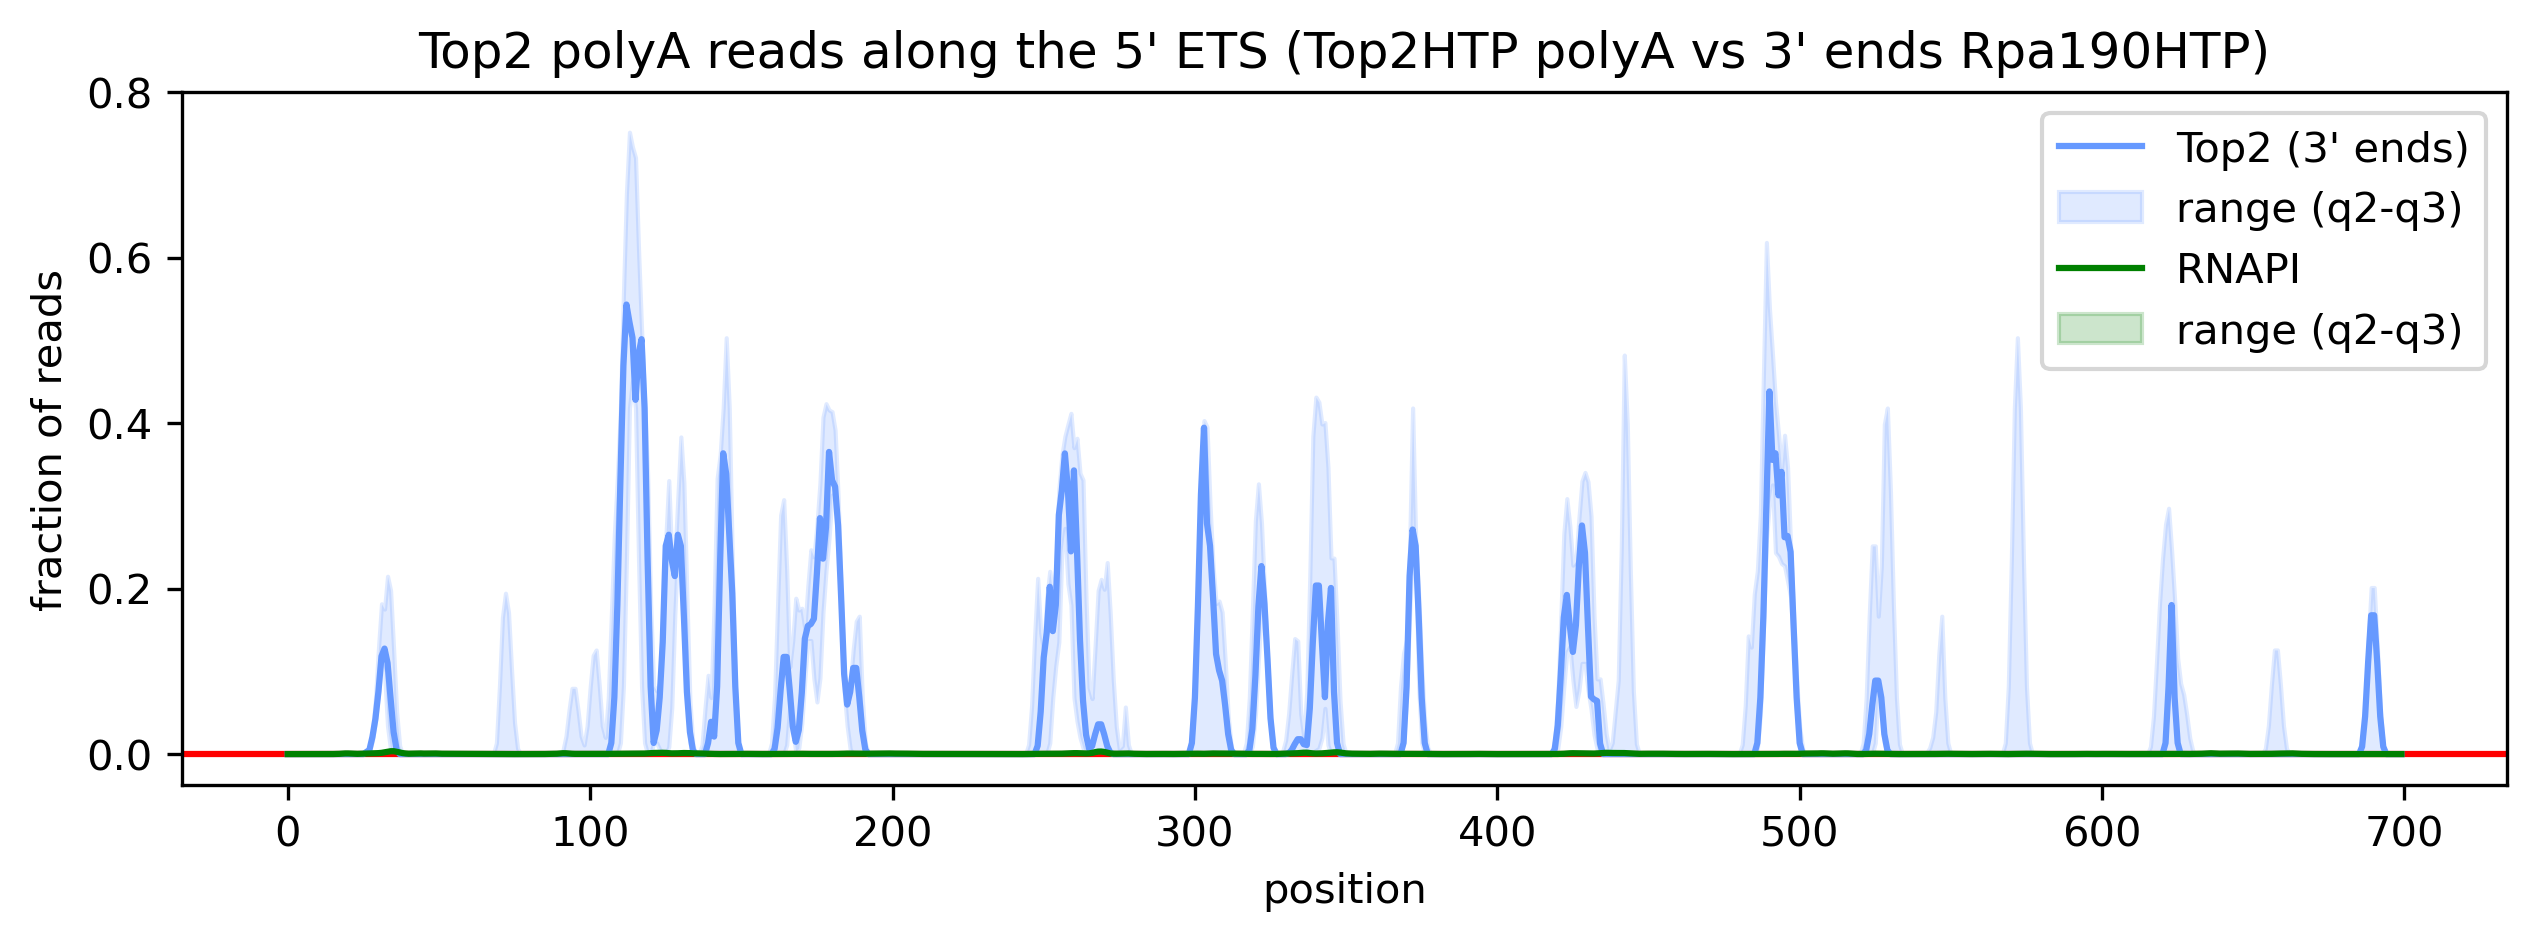

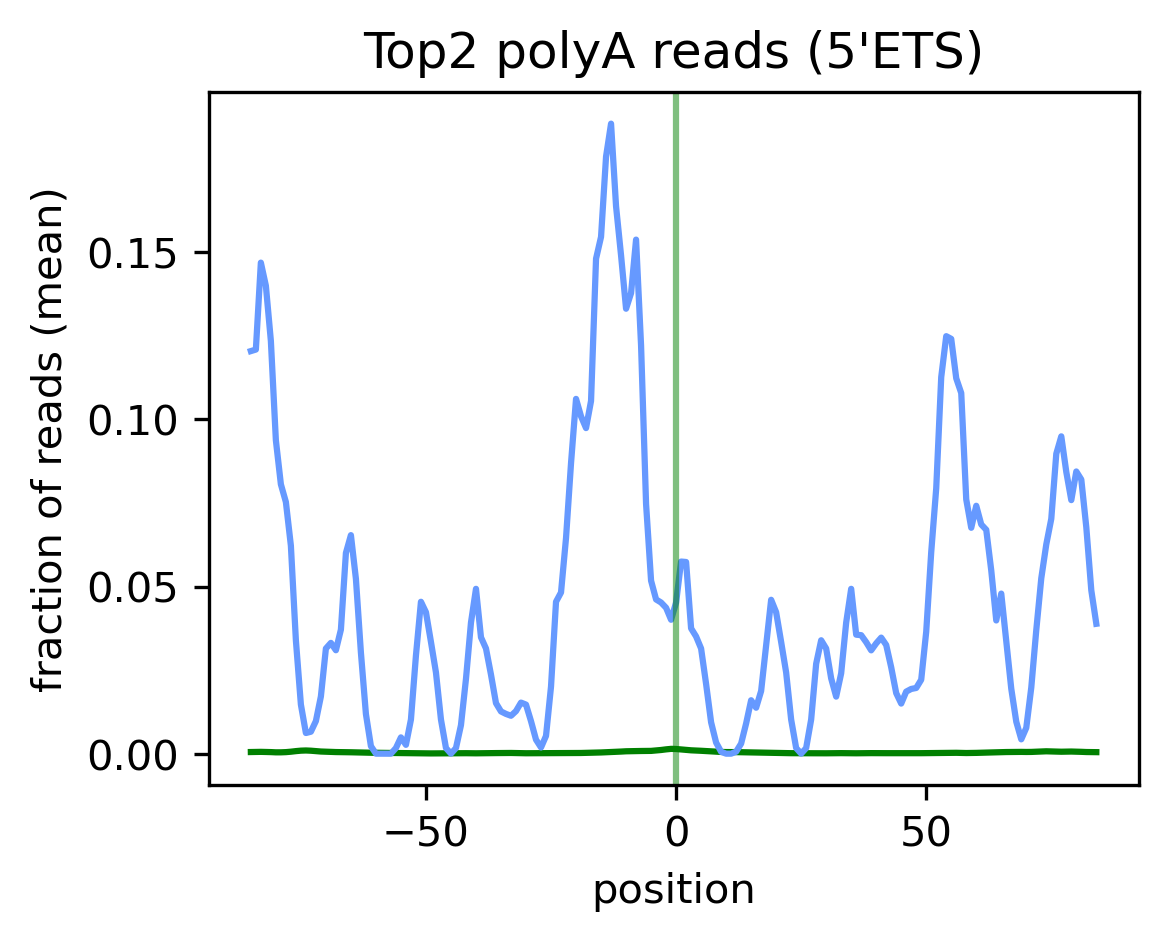

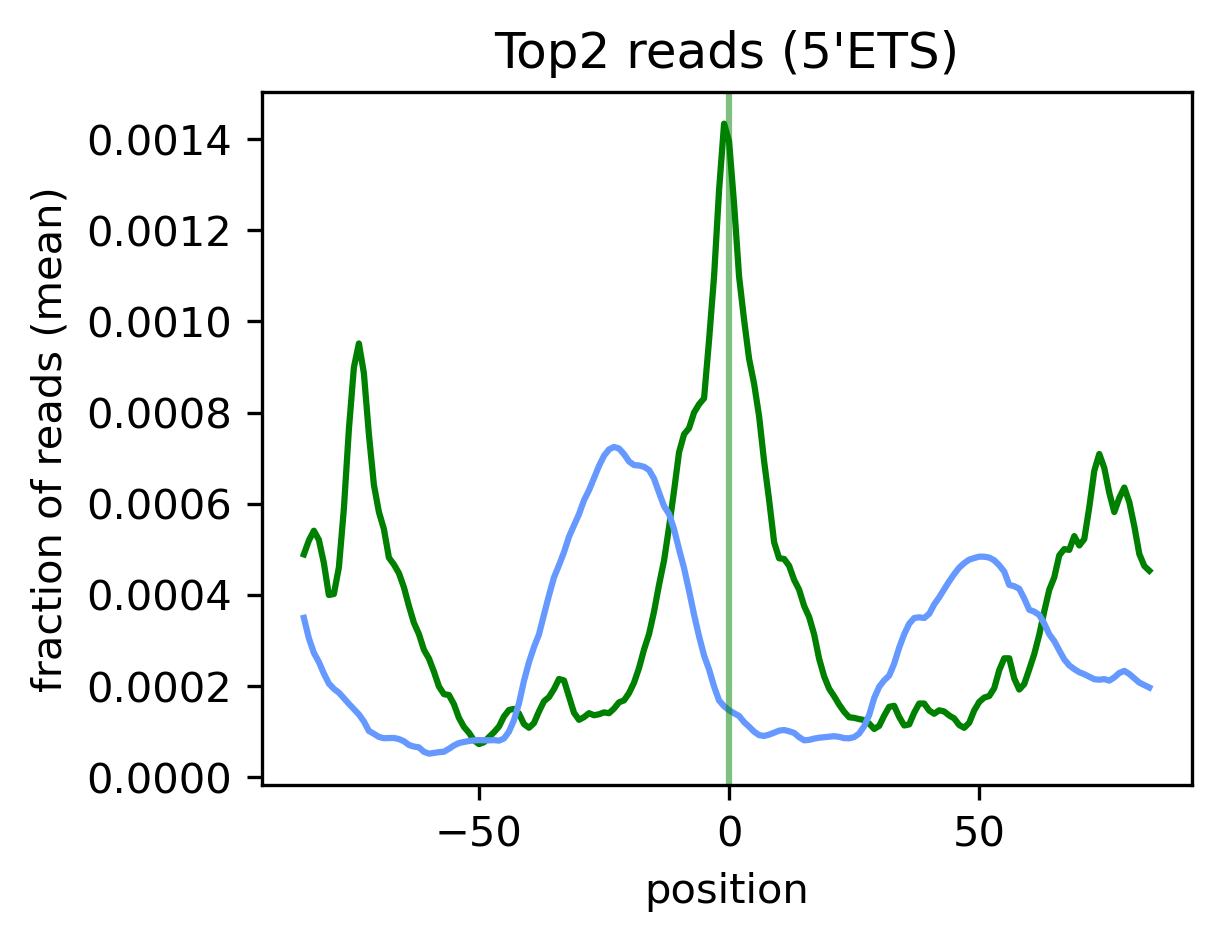

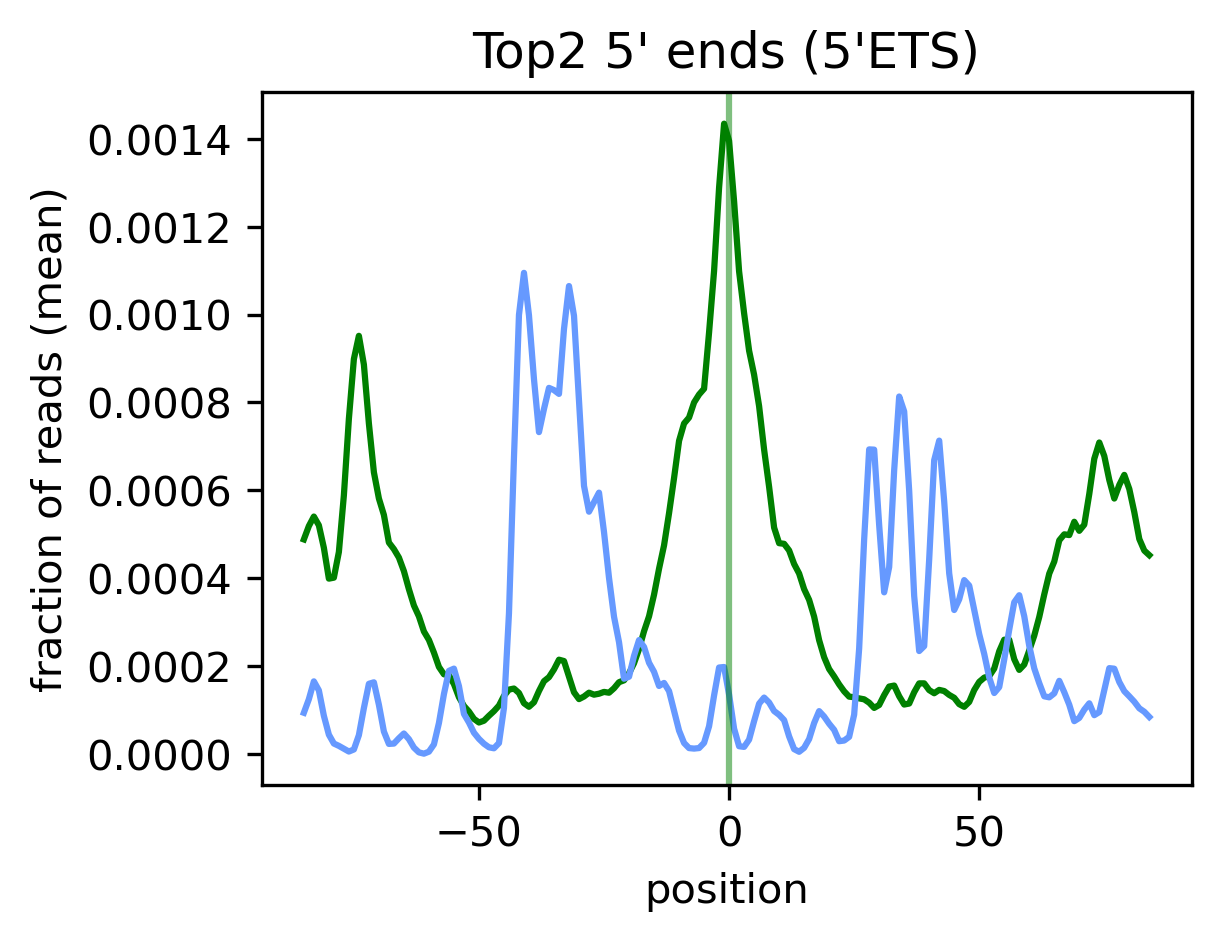

In [14]:
df74_Top2_polyA = polyA_reads(df_raw_all=df01_RDN37_3end, df_raw_polyA=df03_RDN37_polyA,
                                let_in=['Top2'],
                                let_out=['hmo1','0s','25rDNA','UVA',
                                         'Rnt1','rrp44','trf4','air1','rat1',
                                         'h_','C_'],
                                         count=False)

tt.plotting.plot_to_compare(ref=df11_Rpa190_3end, df=df74_Top2_polyA,figsize=(10,3),ref_label="RNAPI",label="Top2 (3' ends)",
                           title="Top2 polyA reads along the 5' ETS (Top2HTP polyA vs 3' ends Rpa190HTP)",
                           dpi=300,offset=300, ylim=(None,0.8),color2='#6699FF',
                           start=0+300, stop=700+300,
                           fname='FIGURES/Fig_5I_related_unused.png')

window = 85

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df74_Top2_polyA, local_pos=peaks, dpi=300,use='mean',
                        title="Top2 polyA reads (5'ETS)", start=None, stop=1000, window=window, figsize=(4,3),
                        color1='green', color2="#6699FF", lc='green',fname="FIGURES/Fig_5I_Top2_polyA.png")

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df72_Top2_reads, local_pos=peaks, dpi=300,use='mean',
                        title="Top2 reads (5'ETS)", start=None, stop=1000, window=window, figsize=(4,3),
                        color1='green', color2="#6699FF", lc='green',fname="FIGURES/Fig_S5E_Top2_reads.png")

df73_Top2_5end = tt.profiles.preprocess(df05_RDN37_5end,
                                     let_in=['Top2'], 
                                     let_out=['hmo1','0s','25rDNA','UVA',
                                         'Rnt1','rrp44','trf4','air1','rat1',
                                         'h_','C_'],stats=True)

tt.plotting.cumulativePeaks(df11_Rpa190_3end, df2=df73_Top2_5end, local_pos=peaks, dpi=300,use='mean',
                        title="Top2 5' ends (5'ETS)", start=300+0, stop=300+700, window=window, figsize=(4,3),
                        color1='green', color2="#6699FF", lc='green',fname="FIGURES/Fig_S5F_Top2_5ends.png")

2.7215415653863135e-104
1.3410182869658075e-25


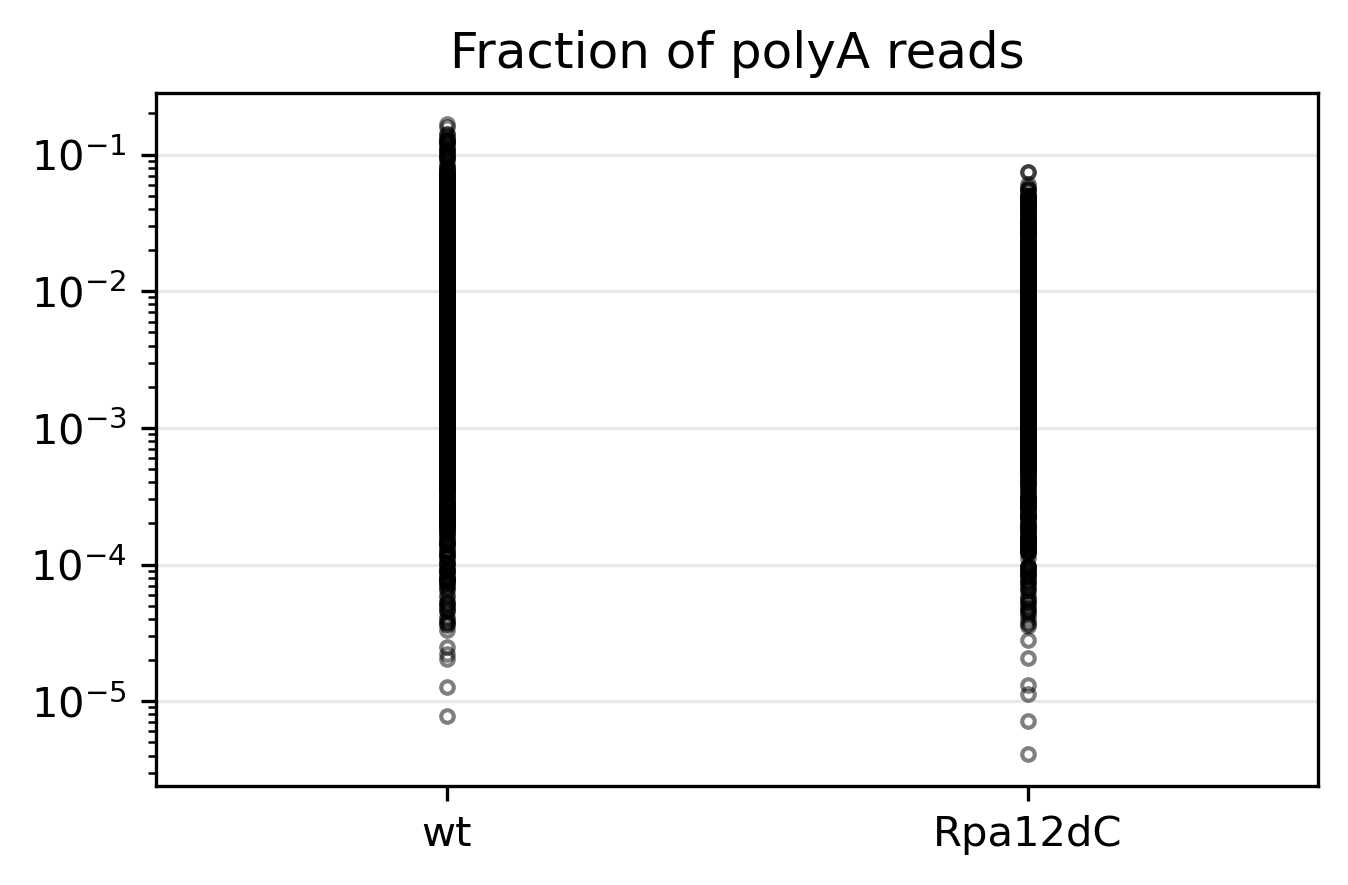

In [15]:
wt = df44_polyA
a12dC = df54_Rpa12dC_polyA

data = [wt['median'].dropna().tolist(),a12dC['median'].dropna().tolist()]
labels=["wt","Rpa12dC"]

tt.plotting.boxplot1(data,labels,grid=True,log=True,figsize=(5,3),dpi=300,fname='FIGURES/Fig_5G_related_polyA_diff_boxplot_unused.png',
                     title="Fraction of polyA reads")

from scipy import stats

out = stats.wilcoxon(wt['median'].fillna(0.0),a12dC['median'].fillna(0.0))
print(out[1])
out = stats.ranksums(wt['median'].fillna(0.0),a12dC['median'].fillna(0.0))
print(out[1])

In [16]:
pd.DataFrame(data=data, index=labels).sum(1)

wt         22.561124
Rpa12dC     7.054115
dtype: float64